In [30]:
import numpy as np
import pyuvdata
from calico import calibration_qa
import importlib
from IPython.display import Image
importlib.reload(calibration_qa)
import matplotlib.pyplot as plt
import casacore.tables as tbl
import os
import shutil

In [11]:
path = "/lustre/pipeline/calibration/results/2026-01-12/05h/successful/20260115_130732/tables/calibration_2026-01-12_05h.B"

In [32]:
def read_caltable_safely(path, tmp_directory="/fast/rbyrne/caltable_temp_dir"):
    """
    This function replaces pyuvdata's UVCal.read() function due to a bug in that function.
    See https://github.com/RadioAstronomySoftwareGroup/pyuvdata/issues/1648.
    """

    if os.path.isfile(path):  # Path is not an ms caltable
        cal = pyuvdata.UVCal()
        cal.read(path)
        return cal

    tb = tbl.table(path, readonly=True)
    if "SPECTRAL_WINDOW_ID" in tb.colnames():
        spw_col = tb.getcol("SPECTRAL_WINDOW_ID")
        unique_spws = np.unique(spw_col)
        unique_spws.sort()
    else:  # Only one spw
        tb.close()
        cal = pyuvdata.UVCal()
        cal.read(path)
        return cal

    for spw in unique_spws:
        tb = tbl.table(path, readonly=True)
        subtable = tb.query(f"SPECTRAL_WINDOW_ID == {spw}")
        subtable.copy(f"{tmp_directory}/temp_spw{spw}.B", deep=True)
        subtable.close()

    tb.close()

    cal_objs = []
    time_array = []
    lst_array = []
    for spw_ind, spw in enumerate(unique_spws):
        cal = pyuvdata.UVCal()
        cal.read(f"{tmp_directory}/temp_spw{spw}.B")
        cal_objs.append(cal)
        time_array.append(np.mean(cal.time_array))
        lst_array.append(np.mean(cal.lst_array))

    for cal_ind, cal in enumerate(cal_objs):
        cal.time_array = np.array([np.mean(time_array)])
        cal.lst_array = np.array([np.mean(lst_array)])
        if cal_ind == 0:
            cal_concat = cal
        else:
            cal_concat.fast_concat(cal, "freq")

    # Delete temporary files
    for spw in unique_spws:
        shutil.rmtree(f"{tmp_directory}/temp_spw{spw}.B")

    return cal_concat

In [34]:
cal = read_caltable_safely(path)

Successful readonly open of default-locked table /lustre/pipeline/calibration/results/2026-01-12/05h/successful/20260115_130732/tables/calibration_2026-01-12_05h.B: 13 columns, 5632 rows
Successful readonly open of default-locked table /lustre/pipeline/calibration/results/2026-01-12/05h/successful/20260115_130732/tables/calibration_2026-01-12_05h.B: 13 columns, 5632 rows
Successful readonly open of default-locked table /lustre/pipeline/calibration/results/2026-01-12/05h/successful/20260115_130732/tables/calibration_2026-01-12_05h.B: 13 columns, 5632 rows
Successful readonly open of default-locked table /lustre/pipeline/calibration/results/2026-01-12/05h/successful/20260115_130732/tables/calibration_2026-01-12_05h.B: 13 columns, 5632 rows
Successful readonly open of default-locked table /lustre/pipeline/calibration/results/2026-01-12/05h/successful/20260115_130732/tables/calibration_2026-01-12_05h.B: 13 columns, 5632 rows
Successful readonly open of default-locked table /lustre/pipeline

Setting telescope_location to value in known_telescopes for OVRO-LWA.
Unknown polarization basis for solutions, jones_array values may be spurious.
Unknown x_orientation basis for solutions, assuming "east".


In [27]:
cal.Ntimes

1

In [21]:
cal_objs[2].time_array

array([2461052.75036897])

In [ ]:
def read_caltable_safely(path):
    """
    This function replaces pyuvdata's UVCal.read() function due to a bug in that function.
    See https://github.com/RadioAstronomySoftwareGroup/pyuvdata/issues/1648.
    """

    cal = pyuvdata.UVCal()

    if os.path.isdir(path):  # Path is an ms caltable

        t = tbl.table(path, readonly=True)

        # Get frequencies
        t_spec_win = tbl.table(
            t.getkeyword("SPECTRAL_WINDOW"), readonly=True, ack=False
        )
        freqs = t_spec_win.getcol("CHAN_FREQ").squeeze()
        bw = t_spec_win.getcol("CHAN_WIDTH").squeeze()
        t_spec_win.close()

        gains = t.getcol("CPARAM")
        times = t.getcol("TIME")
        ants = t.getcol("ANTENNA1")
        flags = t.getcol("FLAG")
        spw_id = t.getcol("SPECTRAL_WINDOW_ID")

        Nspws = len(set(spw_id))
        if Nspws == 1:
            cal.read(path)
        else:  # Manually make cal structure
            cal.Nants_data = len(set(ants))
            cal.Nfreqs = len(set(freqs.flatten()))
            cal.Njones = 2
            cal.Nspws = Nspws
            cal.Ntimes = 1  # Assume only one time
            cal.ant_array = np.unique(ants)
            cal.cal_style = "sky"
            cal.cal_type = "gain"
            cal.channel_width = np.full(cal.Nfreqs, 23925.78125)
            cal.flag_array = np.zeros(
                (cal.Nants_data, cal.Nfreqs, 1, cal.Njones), dtype=bool
            )  # Initialize as zeros
            cal.freq_array = np.unique(freqs.flatten())
            cal.gain_convention = "divide"
            cal.history = path
            cal.integration_time = np.full(cal.Ntimes, 2.0)  # Arbitrary
            cal.jones_array = np.array([-5, -6])
            cal.spw_array = np.unique(spw_id)
            cal.telescope = pyuvdata.Telescope.from_known_telescopes("OVRO-LWA", run_check=False)
            cal.wide_band = False

            cal.gain_array = np.zeros(
                (cal.Nants_data, cal.Nfreqs, 1, cal.Njones), dtype=complex
            )  # Initialize as zeros

            # Assume one time
            """
            cal.time_array = np.array([np.mean(cal.time_array)])
            cal.integration_time = np.array([np.mean(cal.integration_time)])
            cal.lst_array = np.array([np.mean(cal.lst_array)])
            cal.phase_center_id_array = np.array([int(np.mean(cal.phase_center_id_array))])
            cal.quality_array = np.mean(cal.quality_array, axis=2)[:, :, np.newaxis, :]
            cal.scan_number_array = np.array([int(np.mean(cal.scan_number_array))])
            """

            for ant_ind in range(cal.Nants_data):
                for freq_ind in range(cal.Nfreqs):
                    use_ant_inds = np.where(ants == cal.ant_array[ant_ind])
                    use_freq_inds = np.where(freqs == cal.freq_array[freq_ind])
                    fine_channel_ind = use_freq_inds[1]
                    spw = use_freq_inds[0]
                    spw_ind = np.where(spw_id == spw)
                    ant_spw_ind = np.intersect1d(use_ant_inds, spw_ind)
                    cal.gain_array[ant_ind, freq_ind, 0, :] = gains[
                        ant_spw_ind, fine_channel_ind, :
                    ]
                    cal.flag_array[ant_ind, freq_ind, 0, :] = flags[
                        ant_spw_ind, fine_channel_ind, :
                    ]
    else:
        cal.read(path)

    return cal

In [ ]:
cal = read_caltable_safely(path)

Successful readonly open of default-locked table /lustre/pipeline/calibration/results/2026-01-12/05h/successful/20260115_130732/tables/calibration_2026-01-12_05h.B: 13 columns, 5632 rows


TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

In [13]:
cal = pyuvdata.UVCal()
cal.read(path)

Setting telescope_location to value in known_telescopes for OVRO-LWA.
Unknown polarization basis for solutions, jones_array values may be spurious.


IndexError: index 14 is out of bounds for axis 2 with size 8

In [ ]:
path = "/lustre/pipeline/calibration/results/2026-01-12/05h/successful/20260115_130732/tables/calibration_2026-01-12_05h.B.flagged"
t = tbl.table(path, readonly=True)
t_spec_win = tbl.table(
    t.getkeyword("SPECTRAL_WINDOW"), readonly=True, ack=False
)
freqs = t_spec_win.getcol("CHAN_FREQ").squeeze()
bw = t_spec_win.getcol("CHAN_WIDTH").squeeze()
t_spec_win.close()

gains = t.getcol("CPARAM")
times = t.getcol("TIME")
ants = t.getcol("ANTENNA1")
flags = t.getcol("FLAG")
spw_id = t.getcol("SPECTRAL_WINDOW_ID")

Successful readonly open of default-locked table /lustre/pipeline/calibration/results/2026-01-12/05h/successful/20260115_130732/tables/calibration_2026-01-12_05h.B.flagged: 13 columns, 5632 rows


In [ ]:
spw_id

array([ 0,  0,  0, ..., 15, 15, 15], shape=(5632,), dtype=int32)

Successful readonly open of default-locked table /lustre/pipeline/calibration/results/2026-01-12/05h/successful/20260115_130732/tables/calibration_2026-01-12_05h.B.flagged: 13 columns, 5632 rows


TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

In [5]:
cal.check()

ValueError: Required UVParameter _flex_spw_id_array has not been set.

In [ ]:
print(np.shape(freqs))  # Shape nspws, nfreqs_per_spw
print(np.shape(gains))  # Shape nants * nspws, nfreqs_per_spw, npols
print(np.shape(flags))  # Shape nants * nspws, nfreqs_per_spw, npols
print(np.shape(ants))  # Shape nants * nspws
print(np.shape(times))  # Shape nants * nspws

(16, 192)
(5632, 192, 2)
(5632, 192, 2)
(5632,)
(5632,)


In [ ]:
print(np.min(times))
print(np.max(times))

5274903818.1205225
5274903824.27078


In [ ]:
np.shape(cal.gain_array)

(352, 3072, 1, 2)

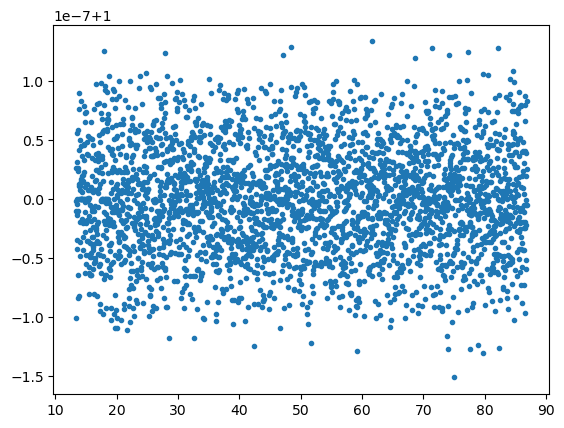

In [ ]:
plt.plot(cal.freq_array/1e6, np.abs(cal.gain_array[350, :, 0,0]), ".")
#plt.ylim([0,.1])

In [ ]:
16*352

5632

In [ ]:
np.shape(cal.gain_array)

(352, 3072, 16, 2)

In [ ]:
cal.ant_array

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
cal = pyuvdata.UVCal()
cal.read(
    "/lustre/pipeline/calibration/results/2026-01-12/02h/successful/20260114_224048/tables/calibration_2026-01-12_02h.B",
    spws=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
)
# calibration_qa.plot_gains(cal, savefig=False)

Setting telescope_location to value in known_telescopes for OVRO-LWA.
Unknown polarization basis for solutions, jones_array values may be spurious.
Unknown x_orientation basis for solutions, assuming "east".


In [ ]:
np.shape(cal.gain_array)

(352, 3072, 16, 2)

In [ ]:
cal.spw_array

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [ ]:
np.shape(cal.freq_array)

(3072,)

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


In [ ]:
print(cal.freq_array)

[13398437.5     13422363.28125 13446289.0625  ... 86826660.15625
 86850585.9375  86874511.71875]


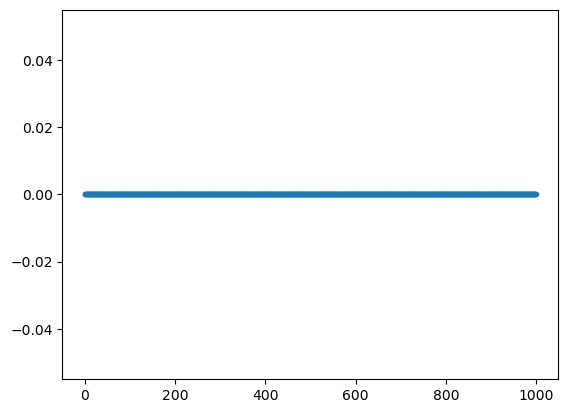

In [ ]:
plt.plot(np.abs(cal.gain_array[3, 1000:2000, 0, 0]), ".")

In [ ]:
import casacore.tables as tbl
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.time import Time


def get_ms_freqs(ms_table):
    t_spec_win = tbl.table(
        ms_table.getkeyword("SPECTRAL_WINDOW"), readonly=True, ack=False
    )
    freqs = t_spec_win.getcol("CHAN_FREQ").squeeze()
    bw = t_spec_win.getcol("CHAN_WIDTH").squeeze()
    t_spec_win.close()
    return freqs

path = "/lustre/pipeline/calibration/results/2026-01-12/02h/successful/20260114_224048/tables/calibration_2026-01-12_02h.B"
t = tbl.table(path, readonly=True)
freqs = get_ms_freqs(t)
gains = t.getcol("CPARAM")
mjds = t.getcol("TIME")[0]
time = Time(mjds / (24 * 3600), format="mjd")

Successful readonly open of default-locked table /lustre/pipeline/calibration/results/2026-01-12/02h/successful/20260114_224048/tables/calibration_2026-01-12_02h.B: 13 columns, 5632 rows


In [ ]:
cal.flex_spw_id_array

array([ 0,  0,  0, ..., 15, 15, 15], shape=(3072,))

In [ ]:
freqs

array([[13398437.5    , 13422363.28125, 13446289.0625 , ...,
        17920410.15625, 17944335.9375 , 17968261.71875],
       [17992187.5    , 18016113.28125, 18040039.0625 , ...,
        22514160.15625, 22538085.9375 , 22562011.71875],
       [22585937.5    , 22609863.28125, 22633789.0625 , ...,
        27107910.15625, 27131835.9375 , 27155761.71875],
       ...,
       [73117187.5    , 73141113.28125, 73165039.0625 , ...,
        77639160.15625, 77663085.9375 , 77687011.71875],
       [77710937.5    , 77734863.28125, 77758789.0625 , ...,
        82232910.15625, 82256835.9375 , 82280761.71875],
       [82304687.5    , 82328613.28125, 82352539.0625 , ...,
        86826660.15625, 86850585.9375 , 86874511.71875]], shape=(16, 192))

In [ ]:
len(set(times))

16

In [ ]:
len(set(ants))

352

In [ ]:
np.shape(gains)

(5632, 192, 2)

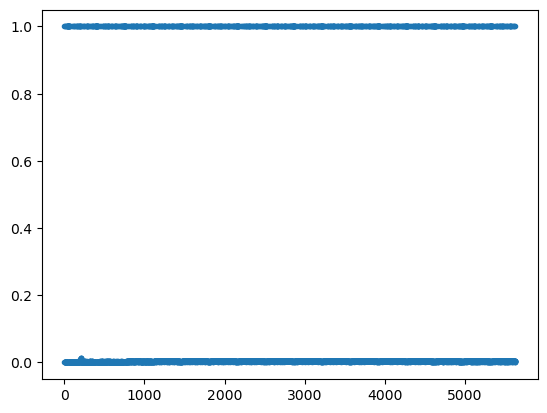

In [ ]:
plt.plot(np.abs(gains[:, 0, 0]), ".")

In [ ]:
cal = pyuvdata.UVCal()
cal.read_ms_cal(
    "/lustre/pipeline/calibration/results/2026-01-12/03h/successful/20260115_070242/tables/calibration_2026-01-12_03h.B.flagged"
)
calibration_qa.plot_gains(cal, savefig=False)

In [ ]:
cal = pyuvdata.UVCal()
cal.read_ms_cal(
    "/lustre/pipeline/calibration/results/2026-01-12/04h/successful/20260115_100643/tables/calibration_2026-01-12_04h.B.flagged"
)
calibration_qa.plot_gains(cal, savefig=False)

In [ ]:
cal = pyuvdata.UVCal()
cal.read_ms_cal(
    "/lustre/pipeline/calibration/results/2026-01-12/05h/successful/20260115_130732/tables/calibration_2026-01-12_05h.B.flagged"
)
calibration_qa.plot_gains(cal, savefig=False)

In [ ]:
cal = pyuvdata.UVCal()
cal.read_ms_cal(
    "/lustre/pipeline/calibration/results/2026-01-12/23h/successful/20260115_162611/tables/calibration_2026-01-12_23h.B"
)
calibration_qa.plot_gains(cal, savefig=False)

In [ ]:
cal = pyuvdata.UVCal()
cal.read_ms_cal(
    "/lustre/pipeline/calibration/results/2026-01-11/22h/successful/20260114_164120/tables/calibration_2026-01-11_22h.B.flagged"
)
calibration_qa.plot_gains(cal, savefig=False)

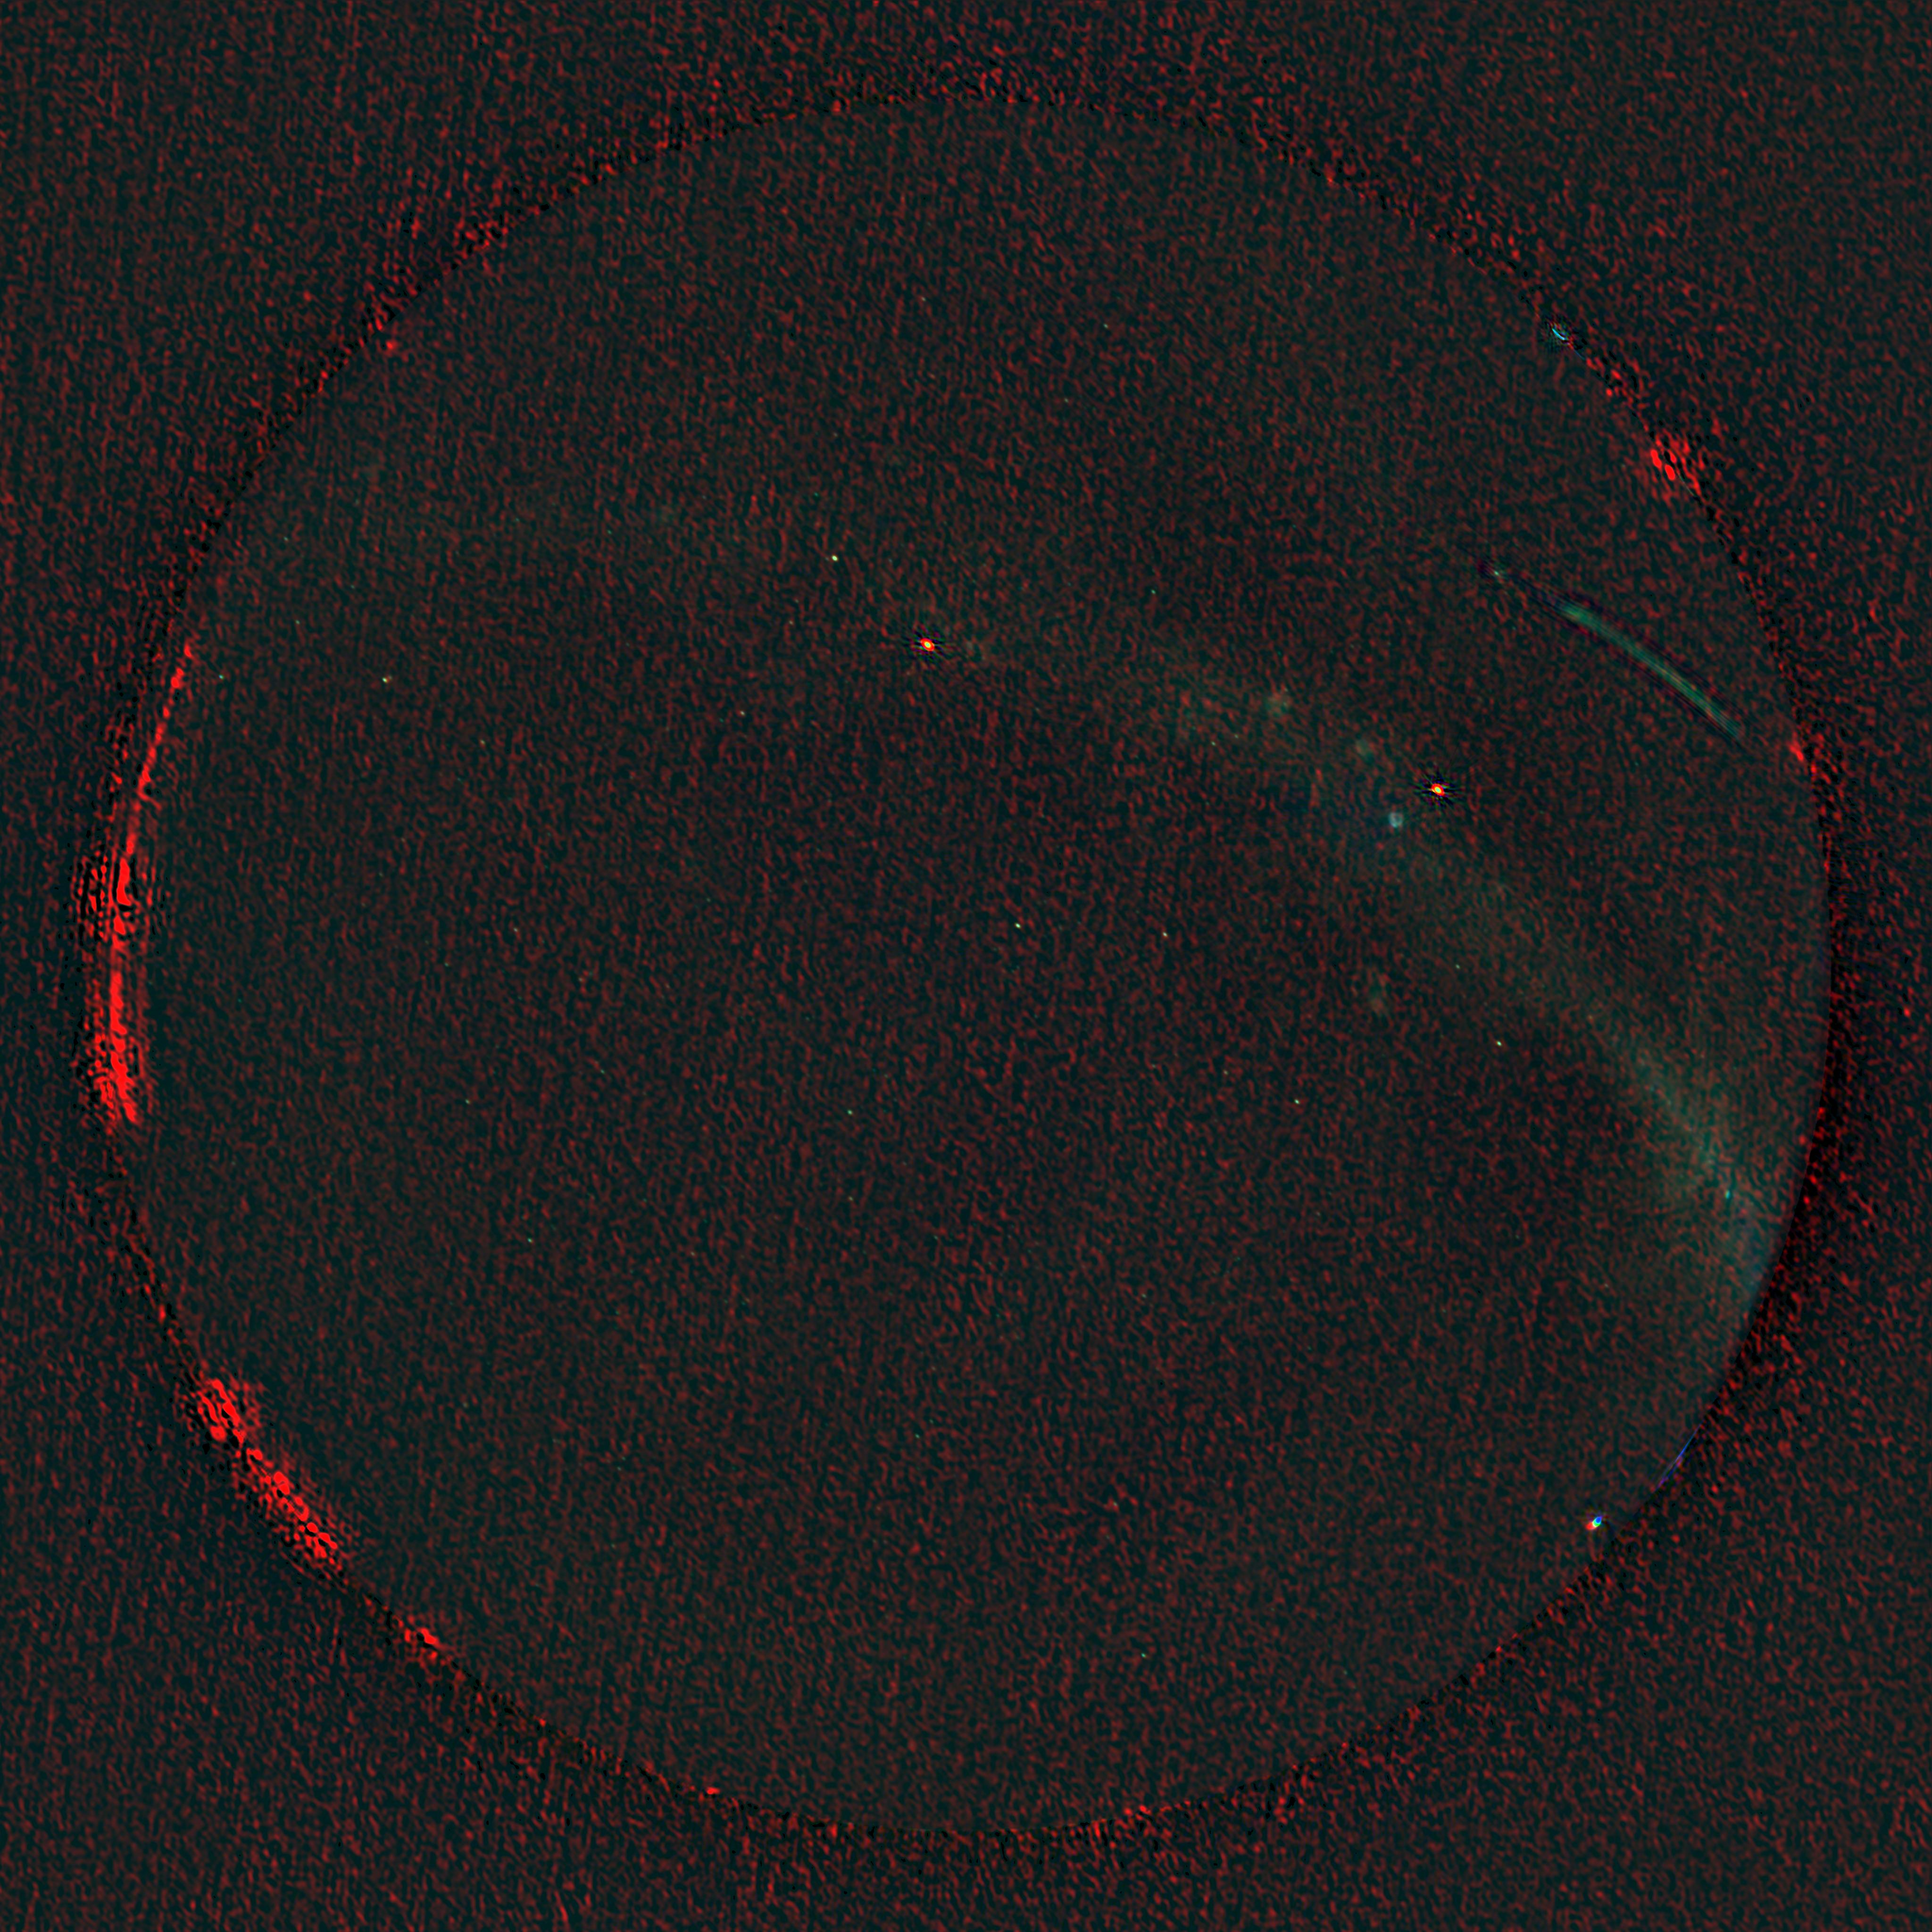

In [ ]:
Image(
    filename="/lustre/pipeline/calibration/results/2026-01-12/23h/successful/20260115_162611/QA/QA_3color_allsky_2026-01-12_23h.jpg"
)

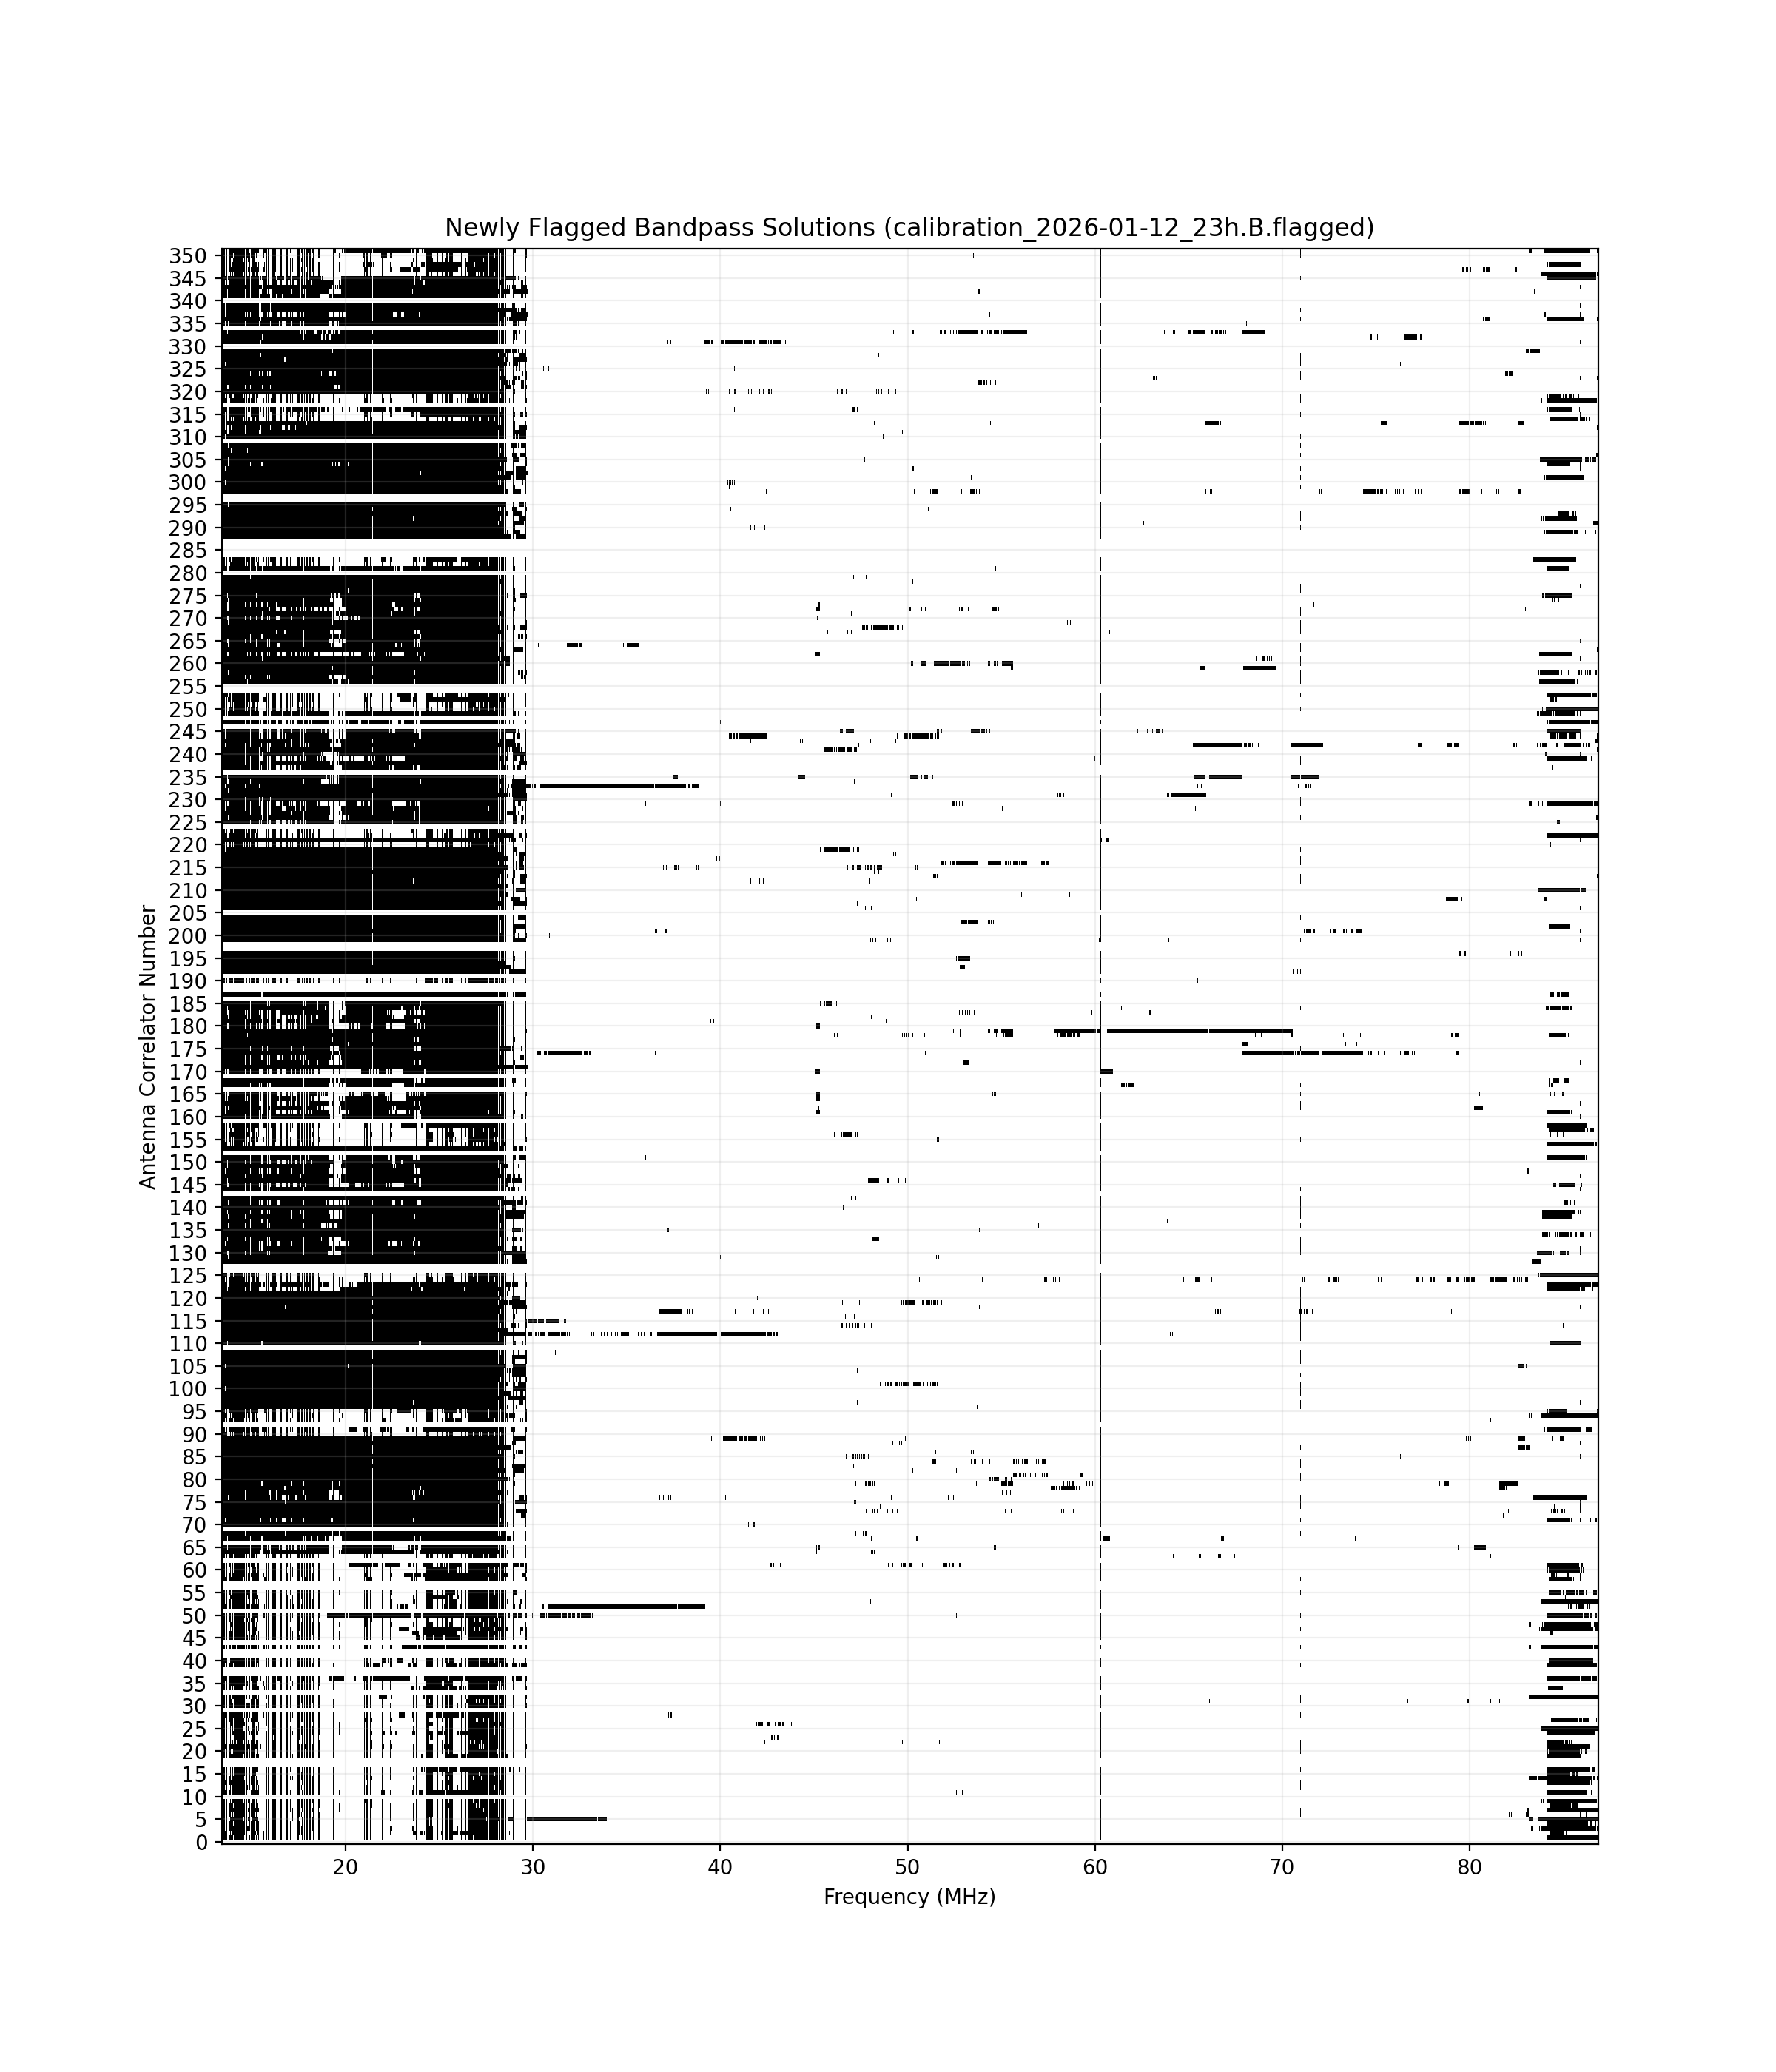

In [ ]:
Image(
    filename="/lustre/pipeline/calibration/results/2026-01-12/23h/successful/20260115_162611/QA/QA_plot_bandpass_flag_summary_2026-01-12_23h.png"
)

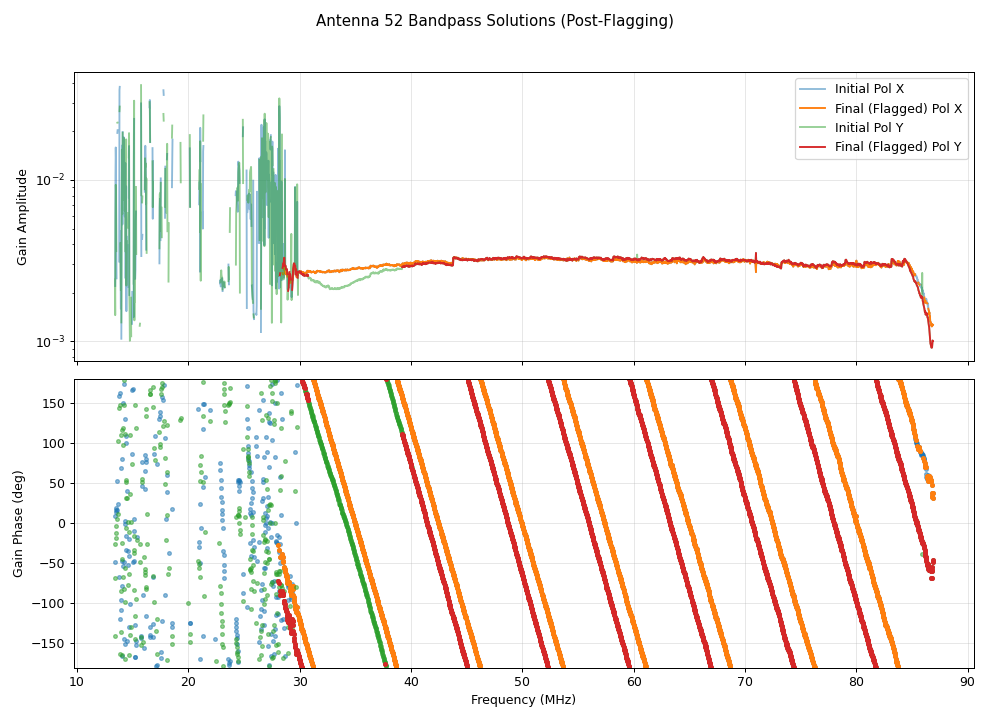

In [ ]:
Image(
    filename="/lustre/pipeline/calibration/results/2026-01-12/23h/successful/20260115_162611/QA/QA_website/bandpass_plots/bp_ant_052.png"
)

Setting telescope_location to value in known_telescopes for OVRO-LWA.
Unknown polarization basis for solutions, jones_array values may be spurious.
Unknown x_orientation basis for solutions, assuming "east".


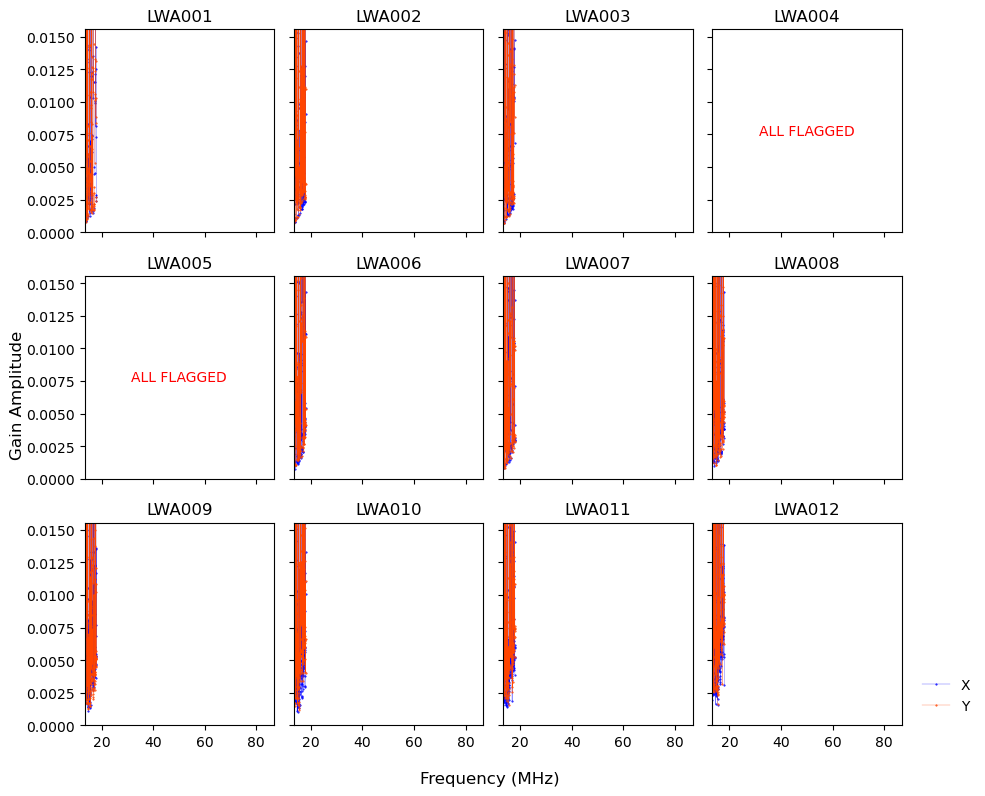

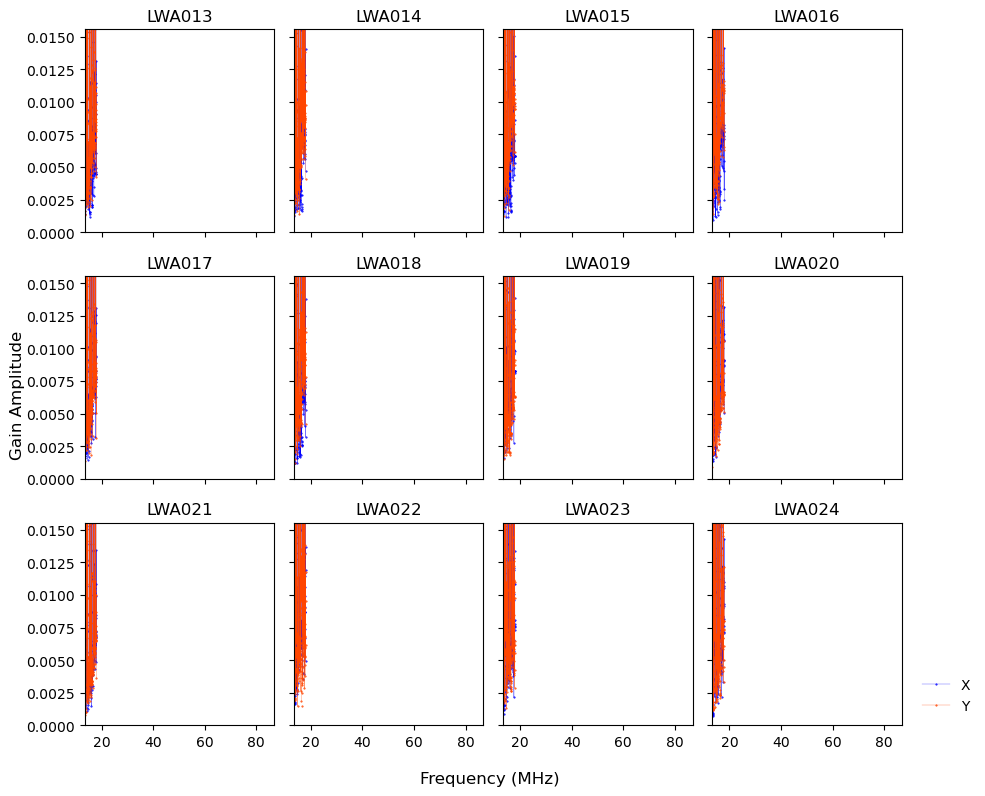

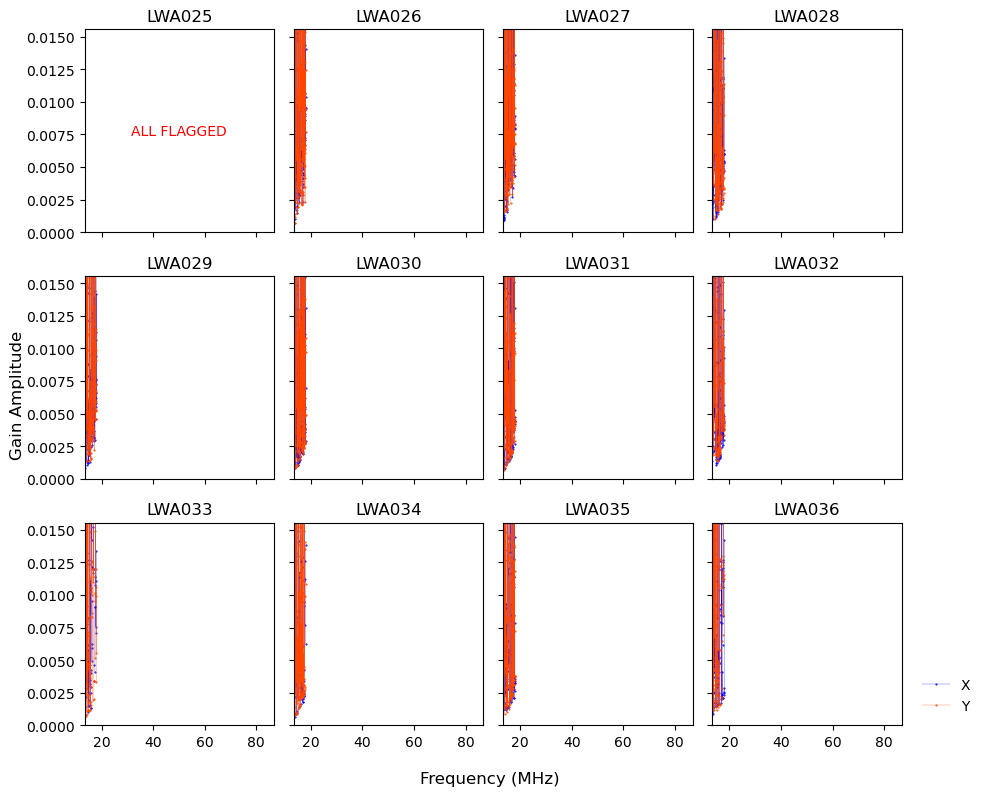

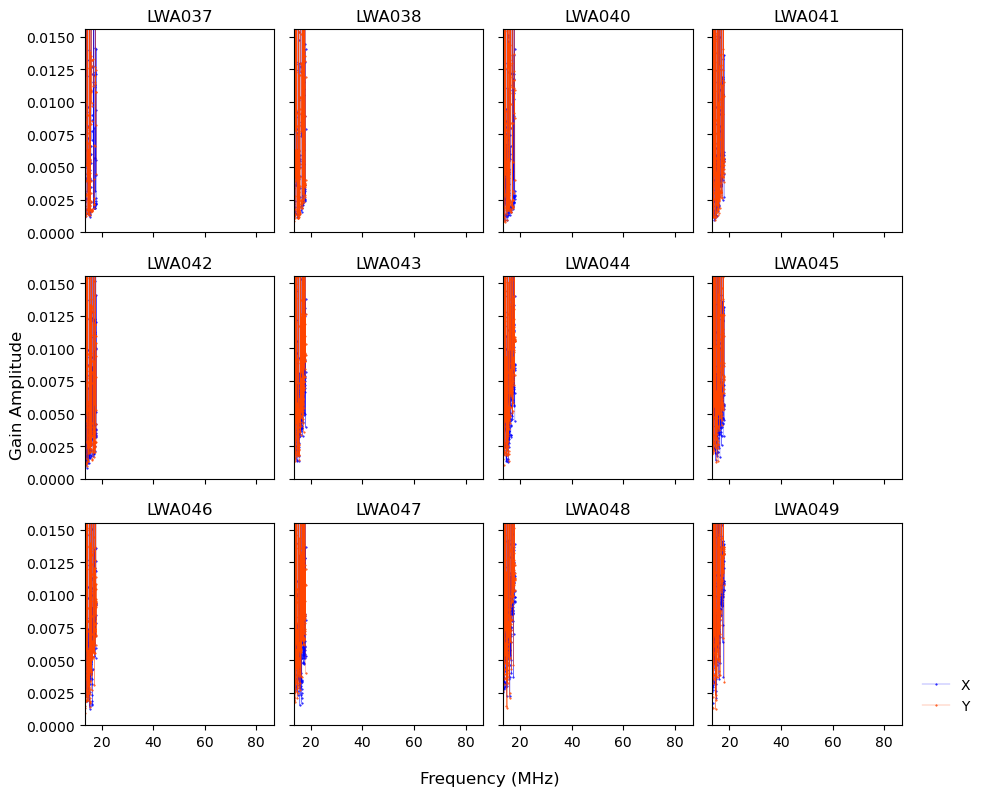

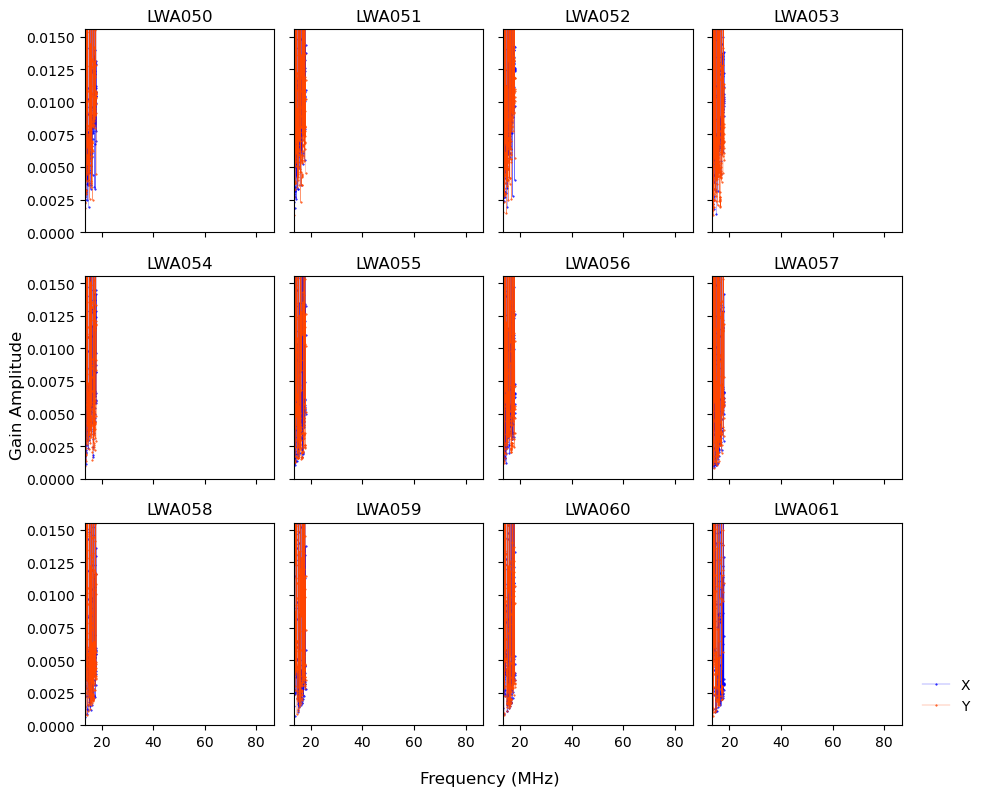

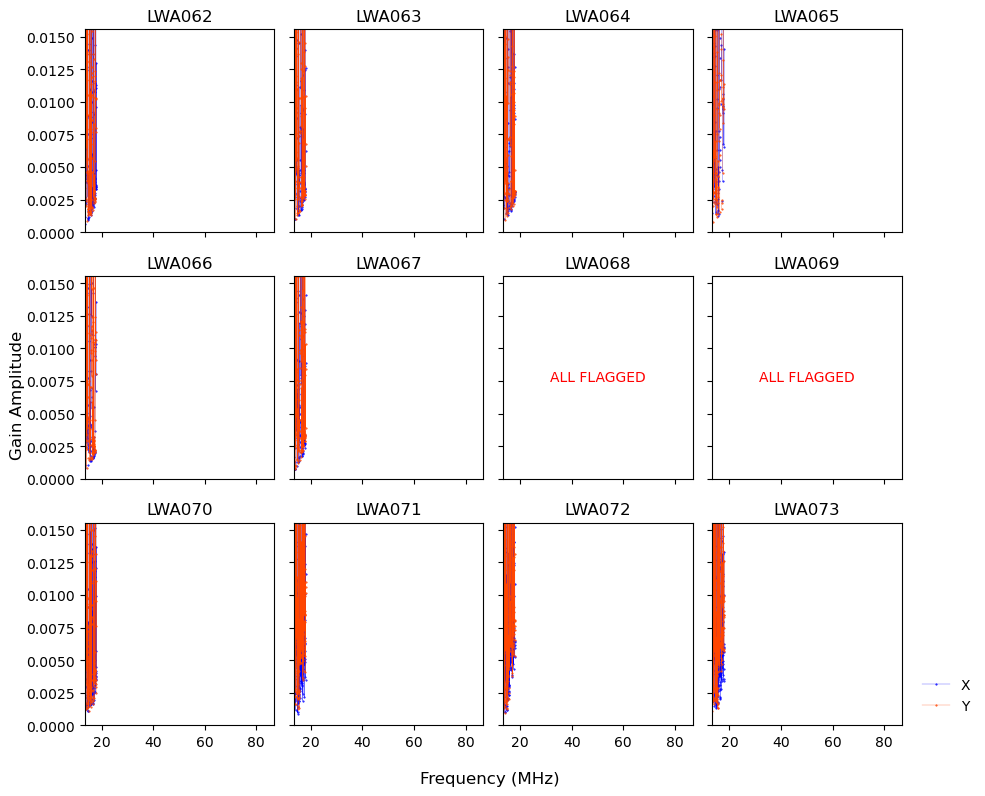

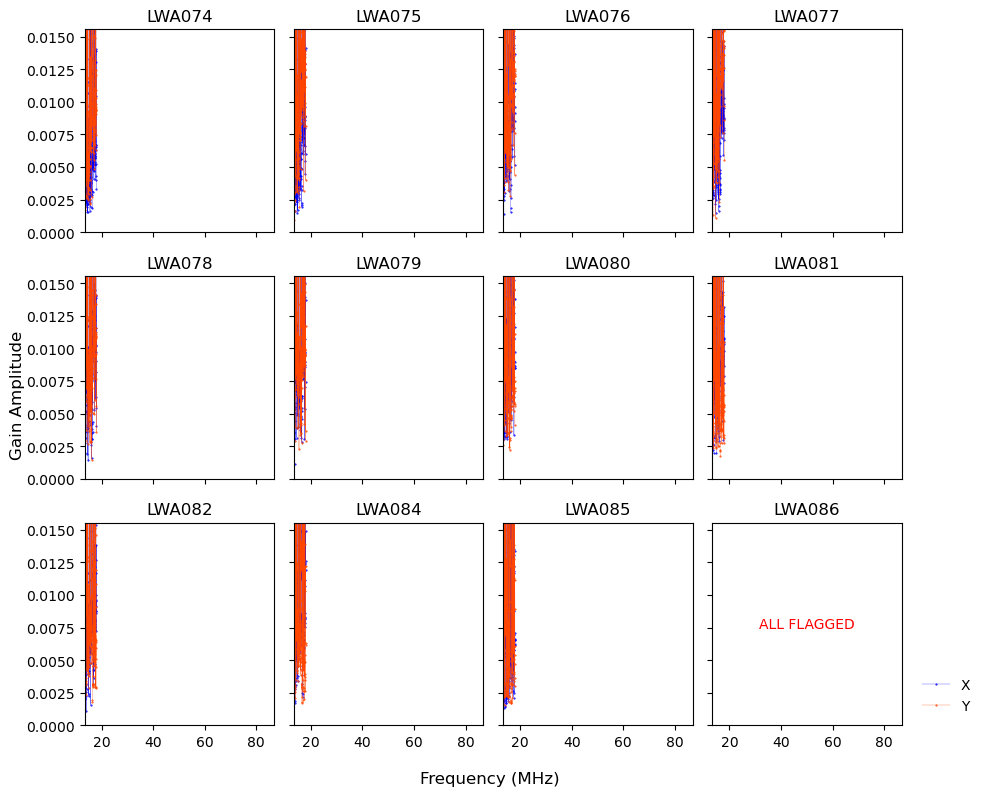

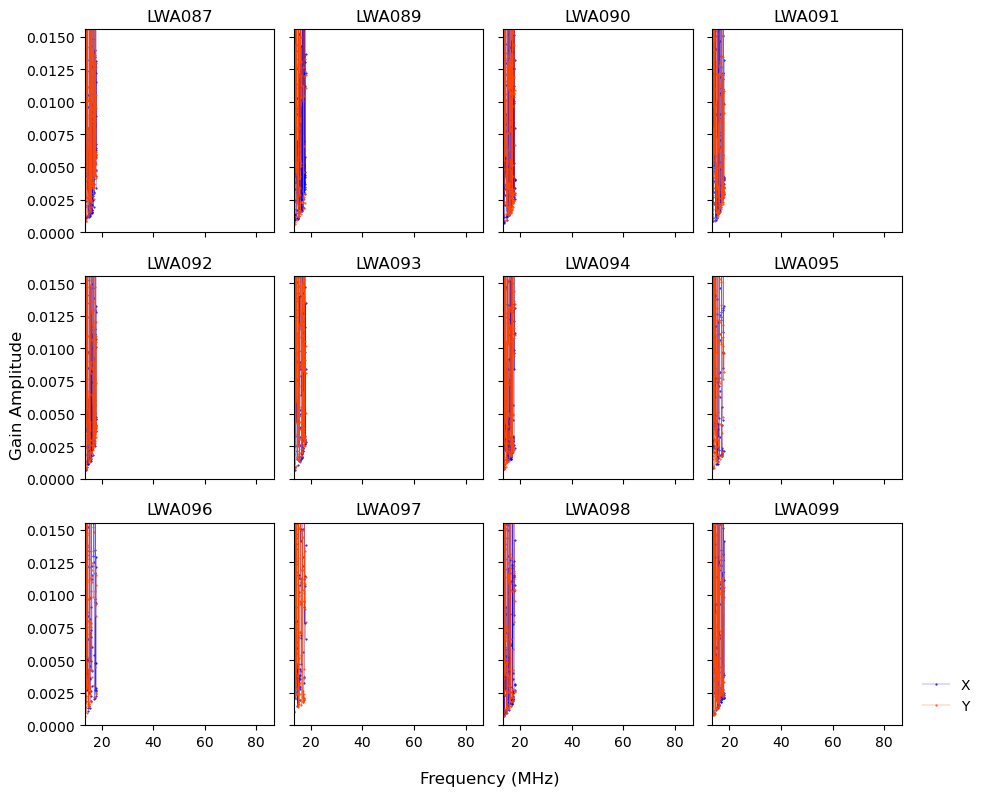

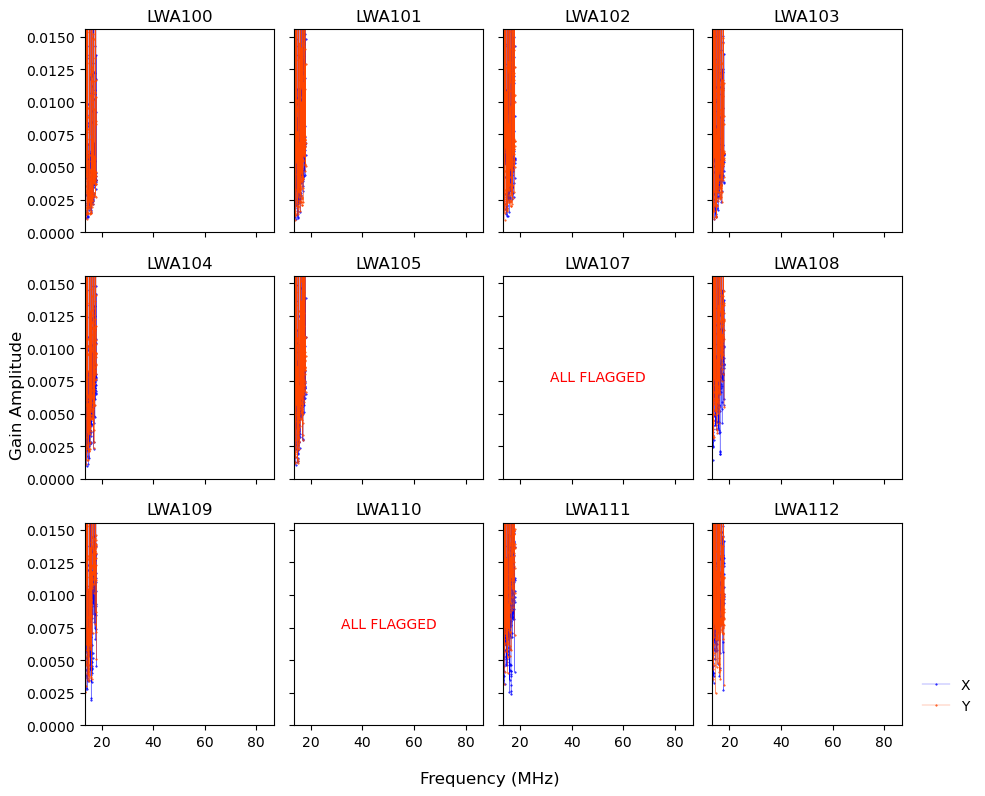

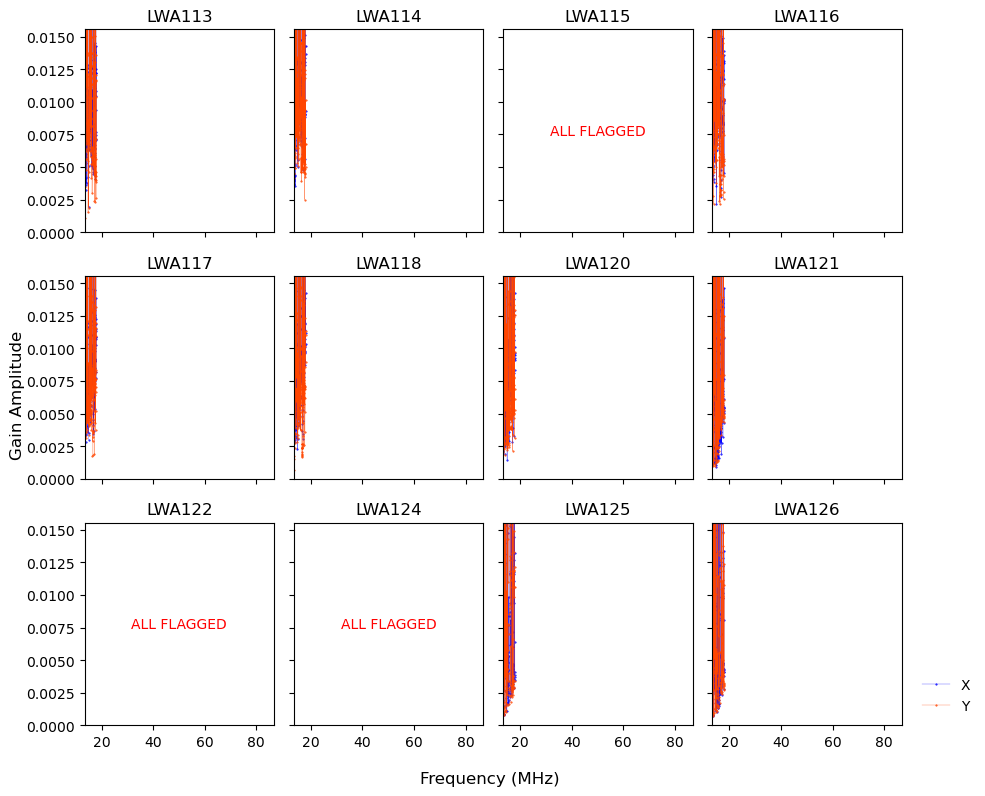

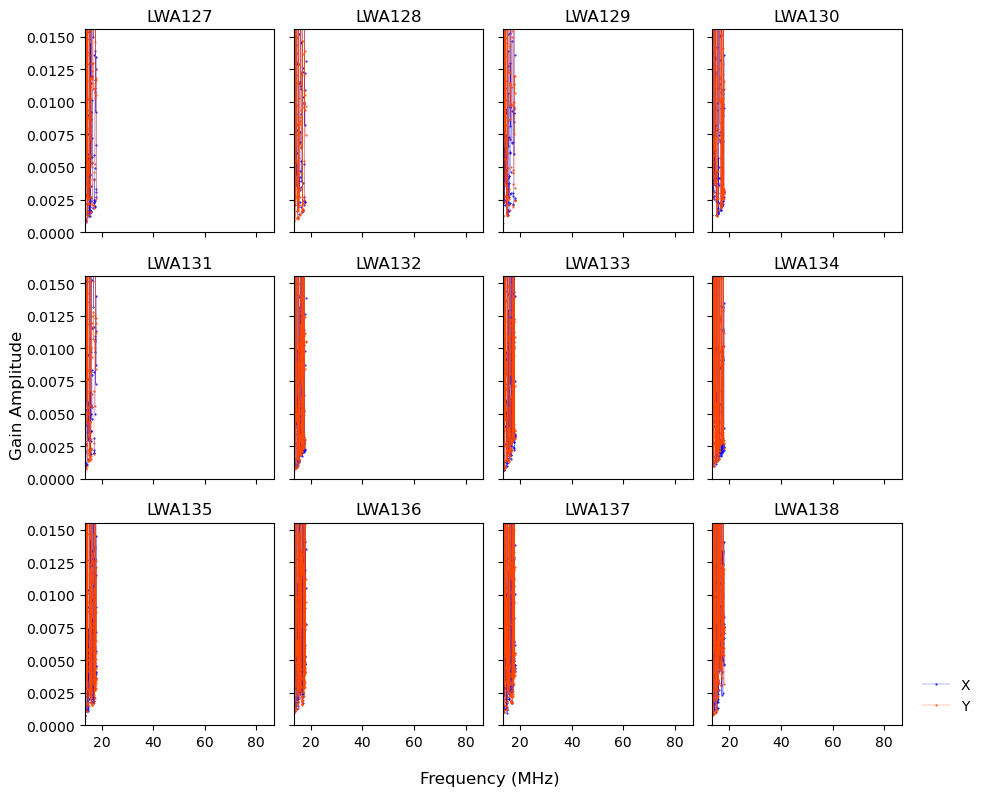

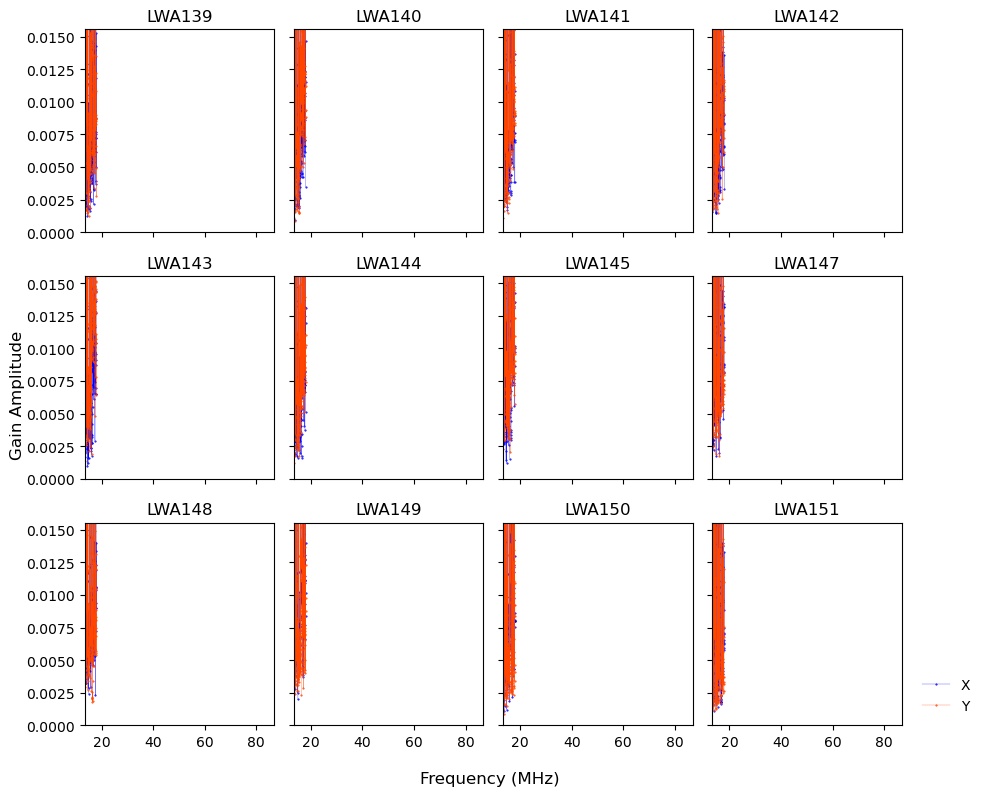

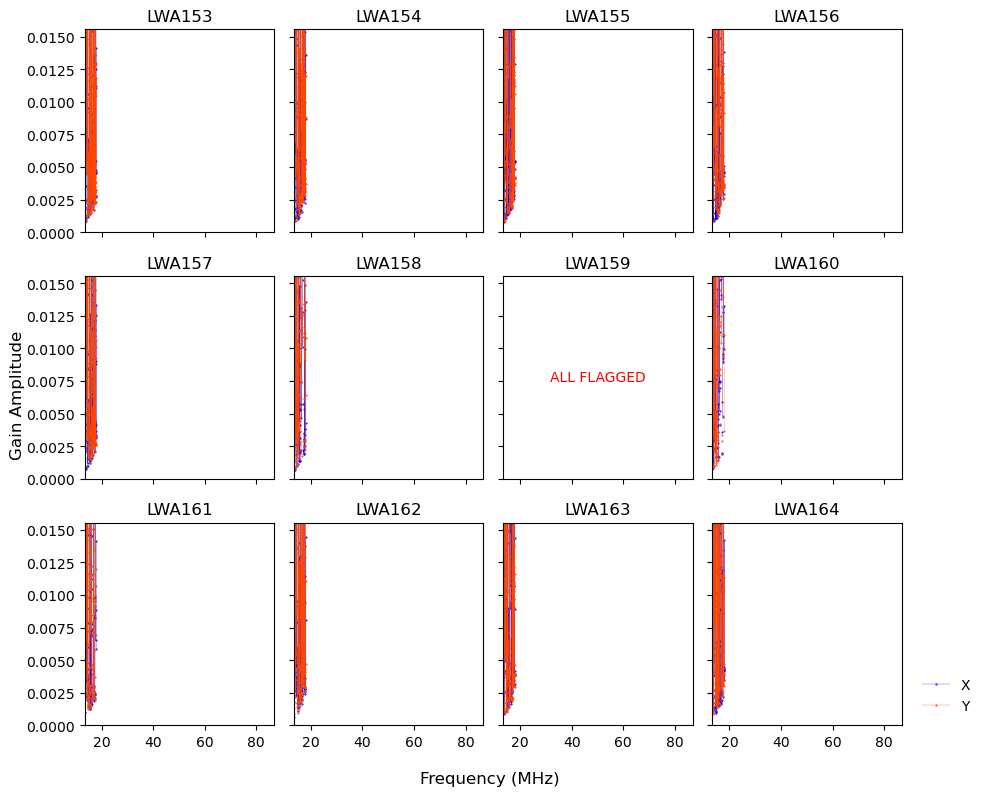

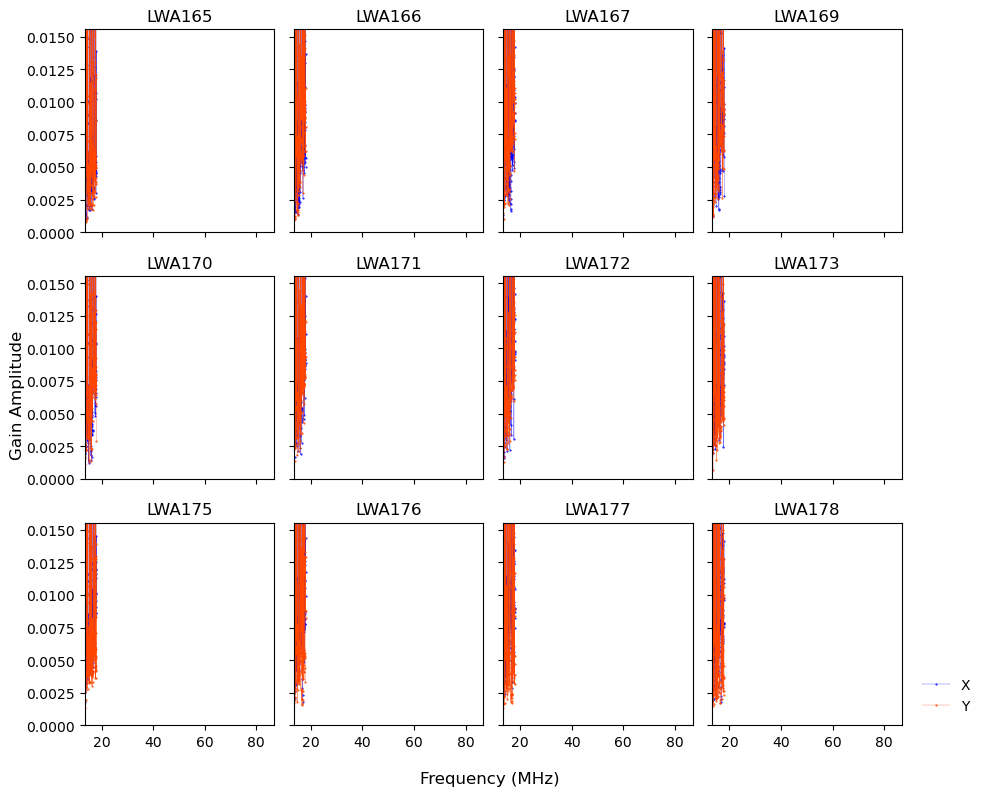

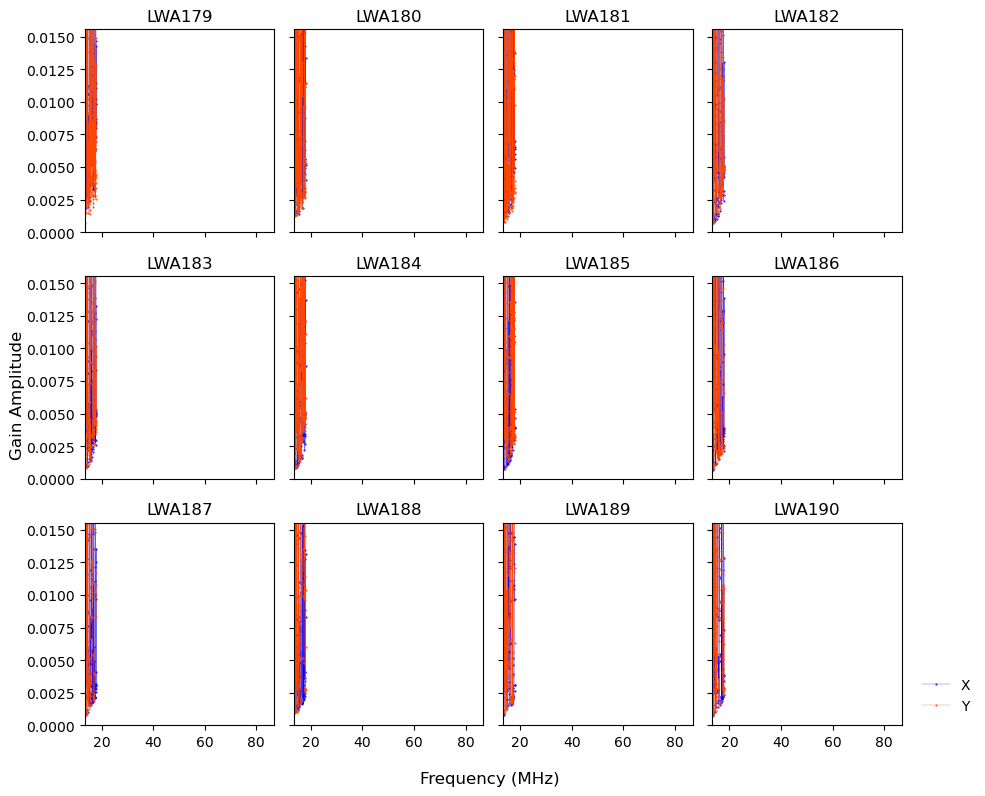

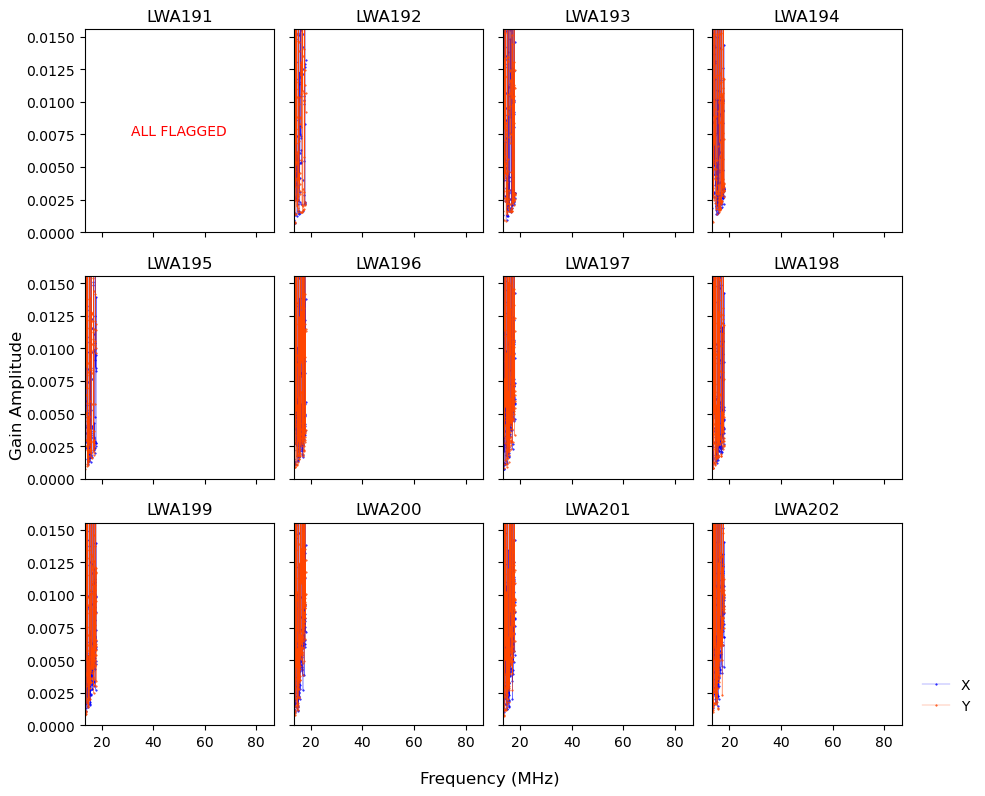

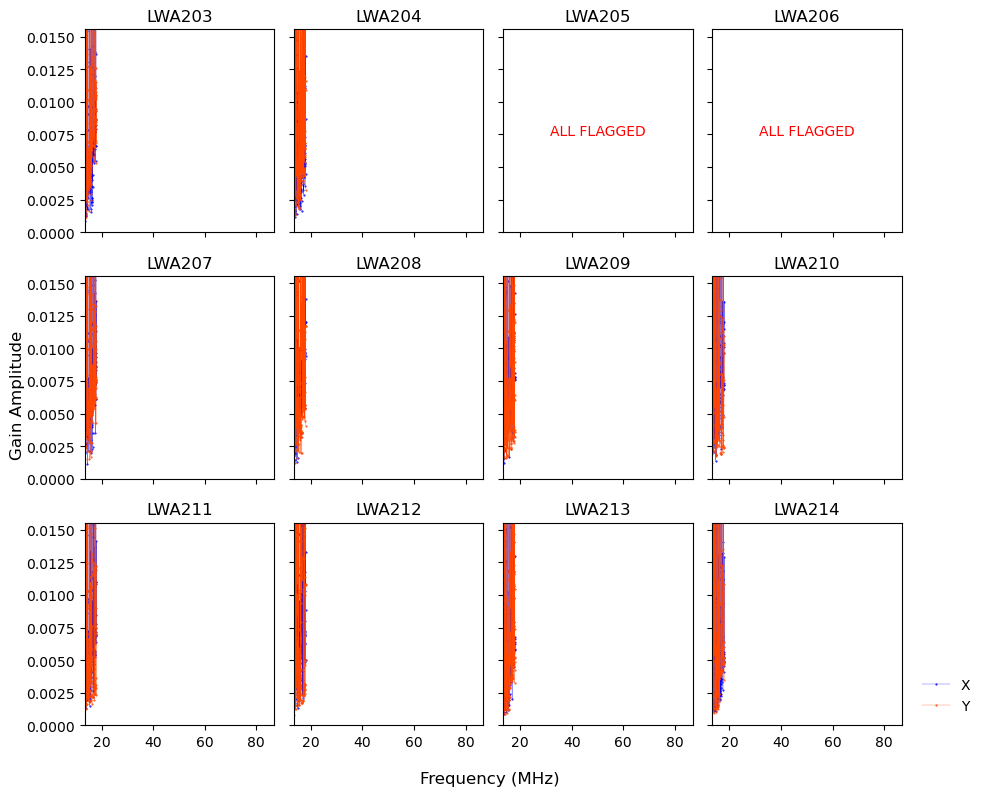

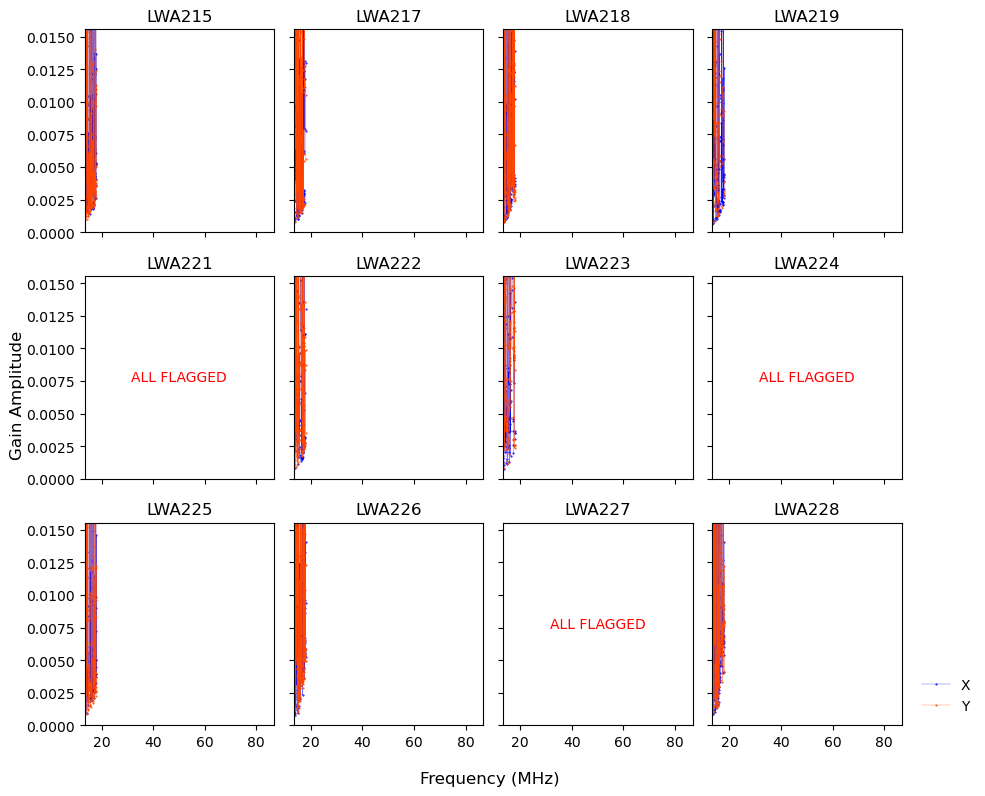

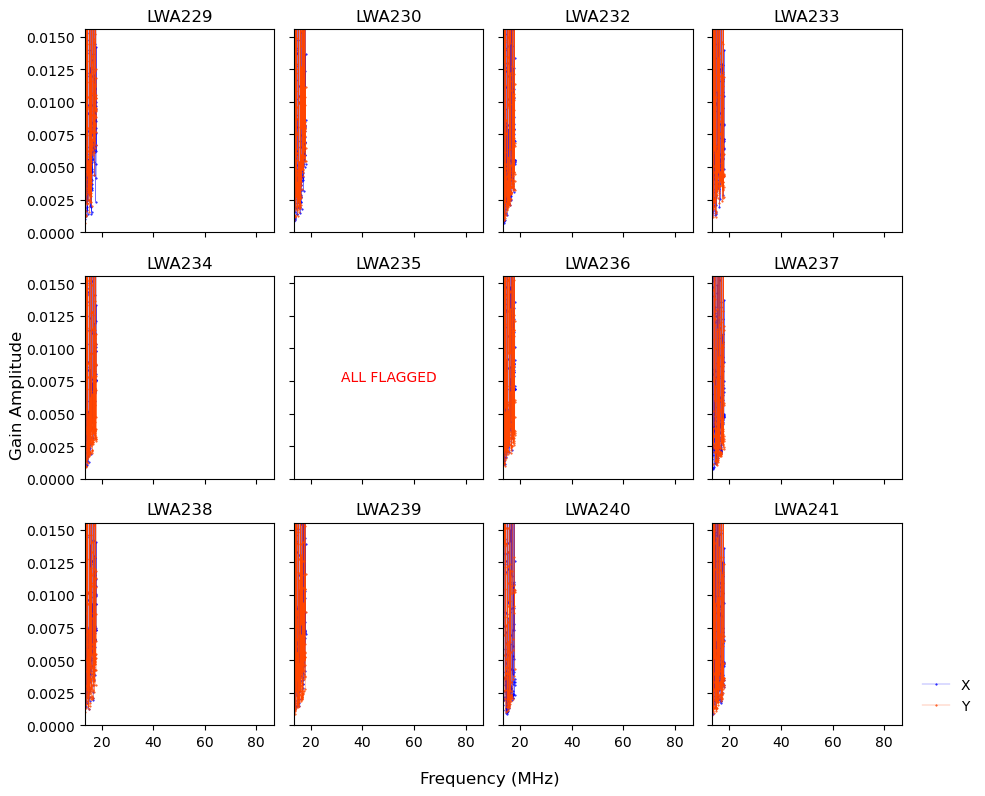

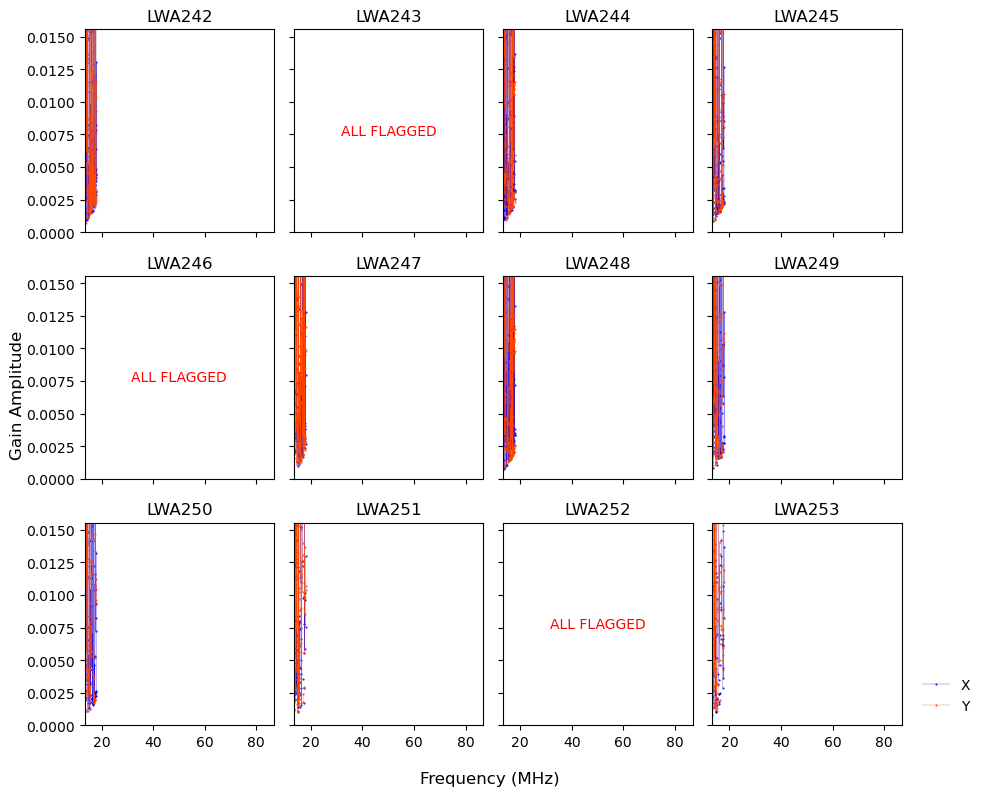

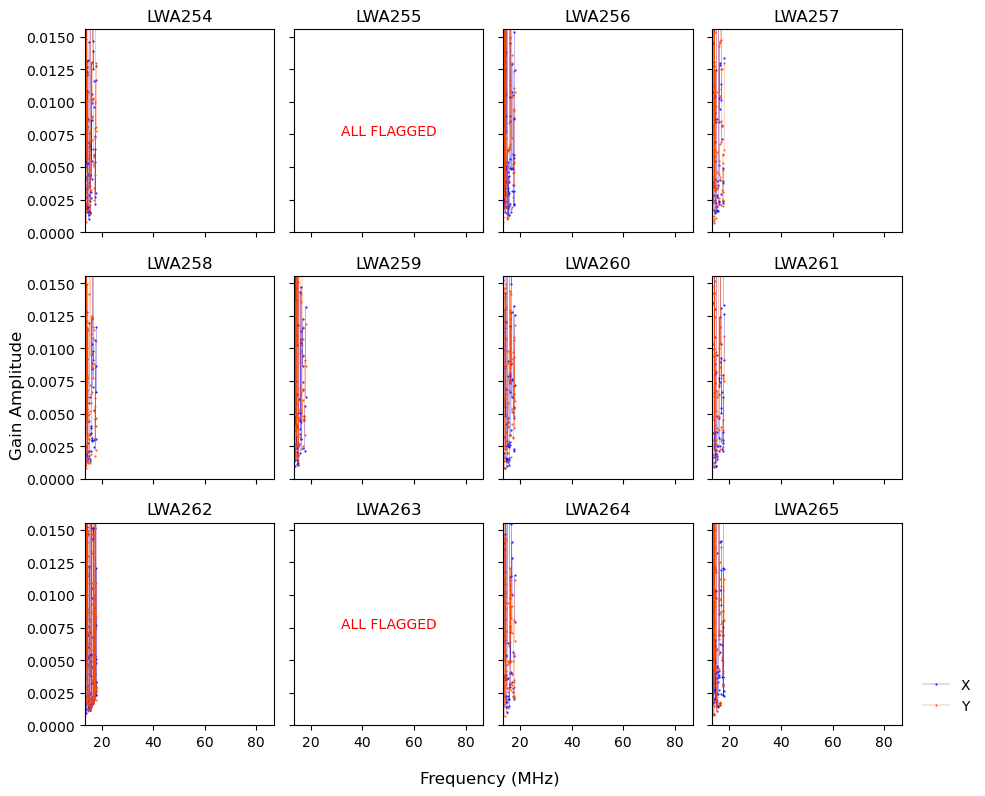

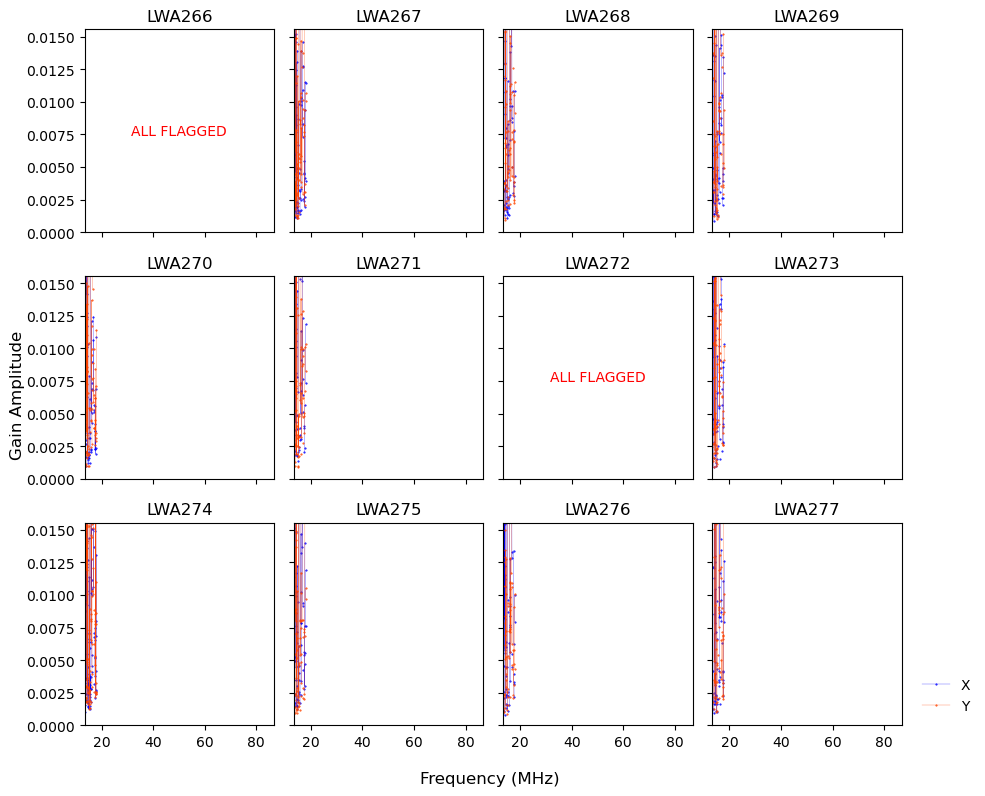

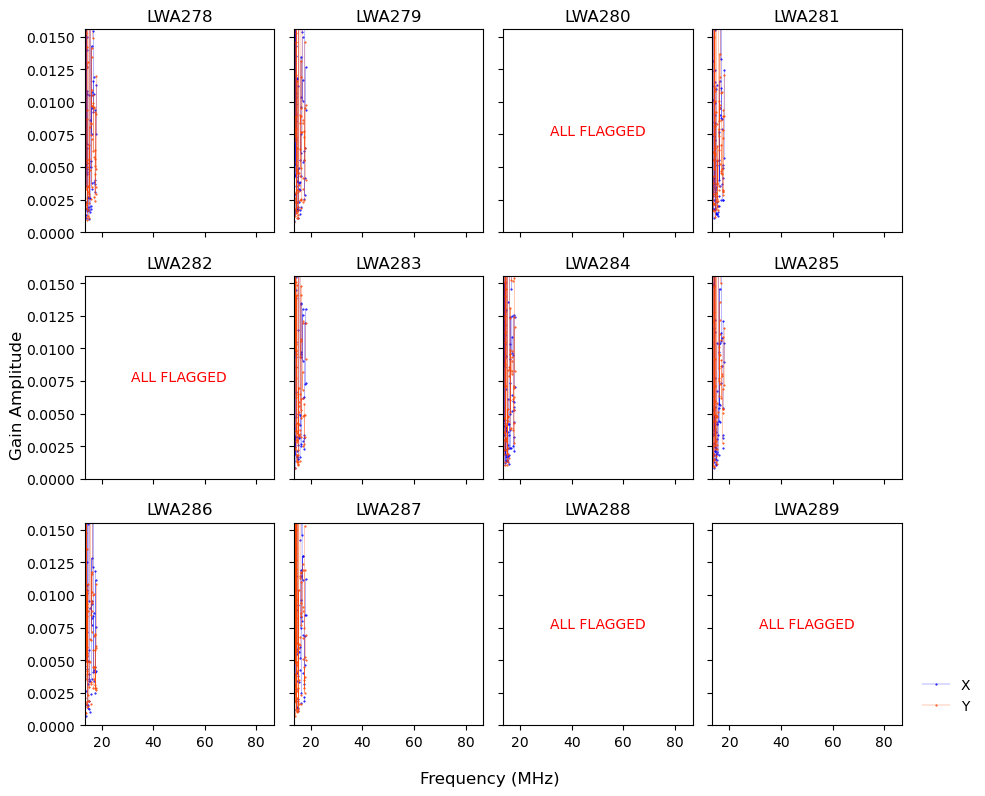

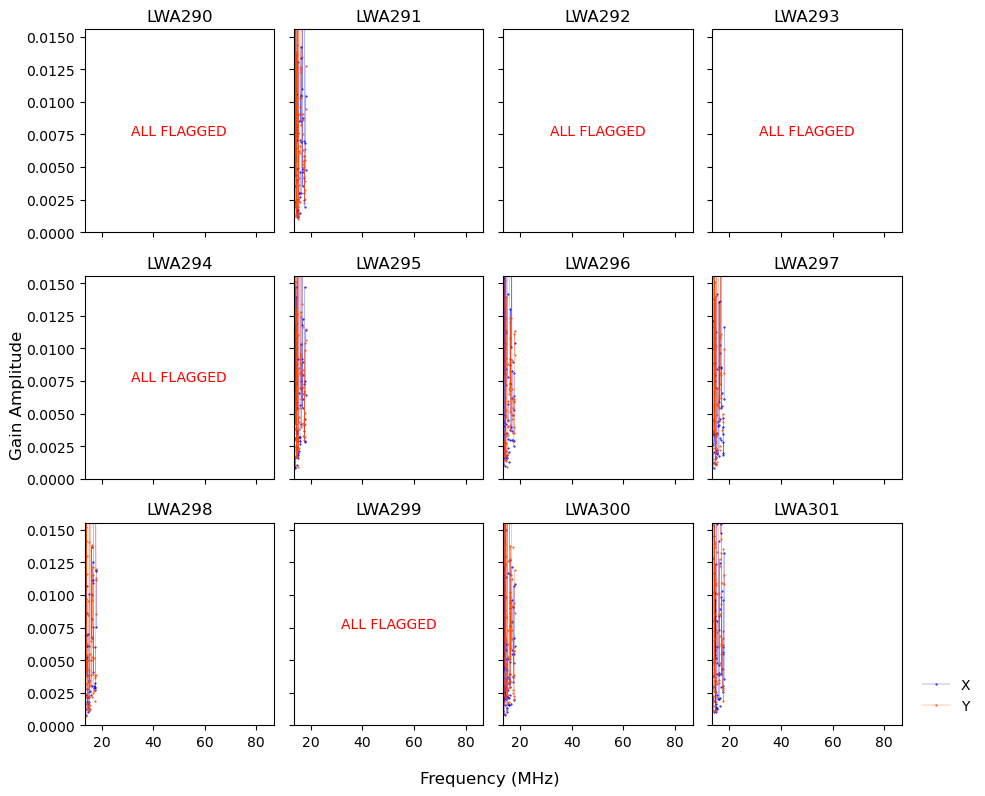

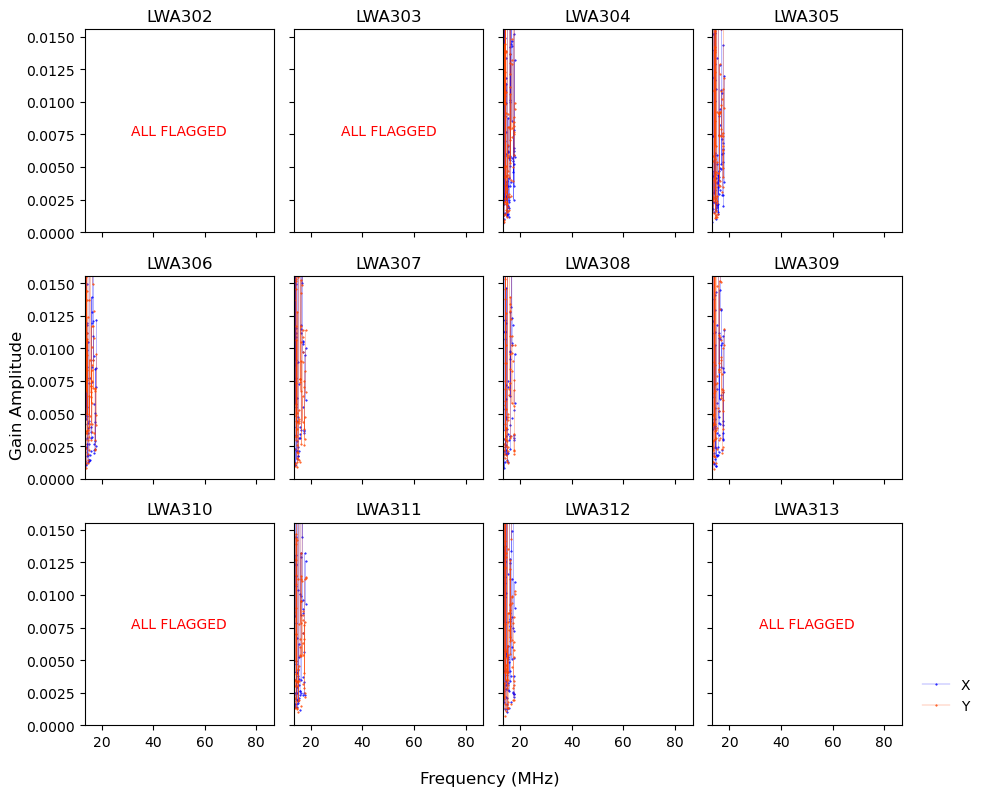

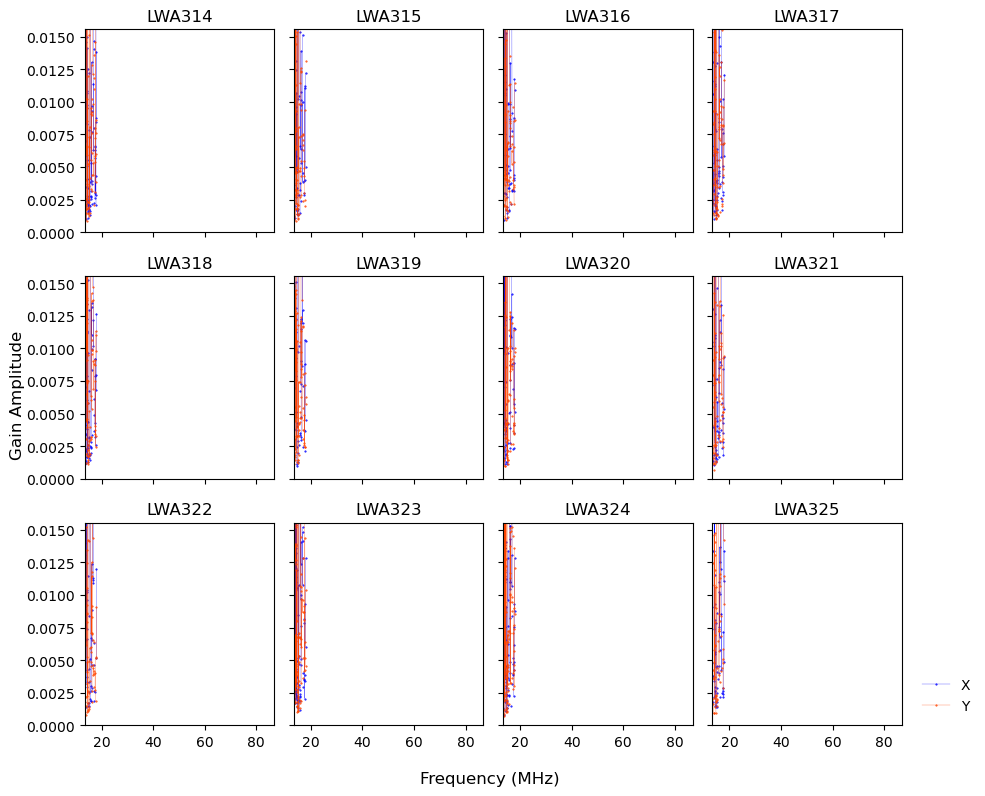

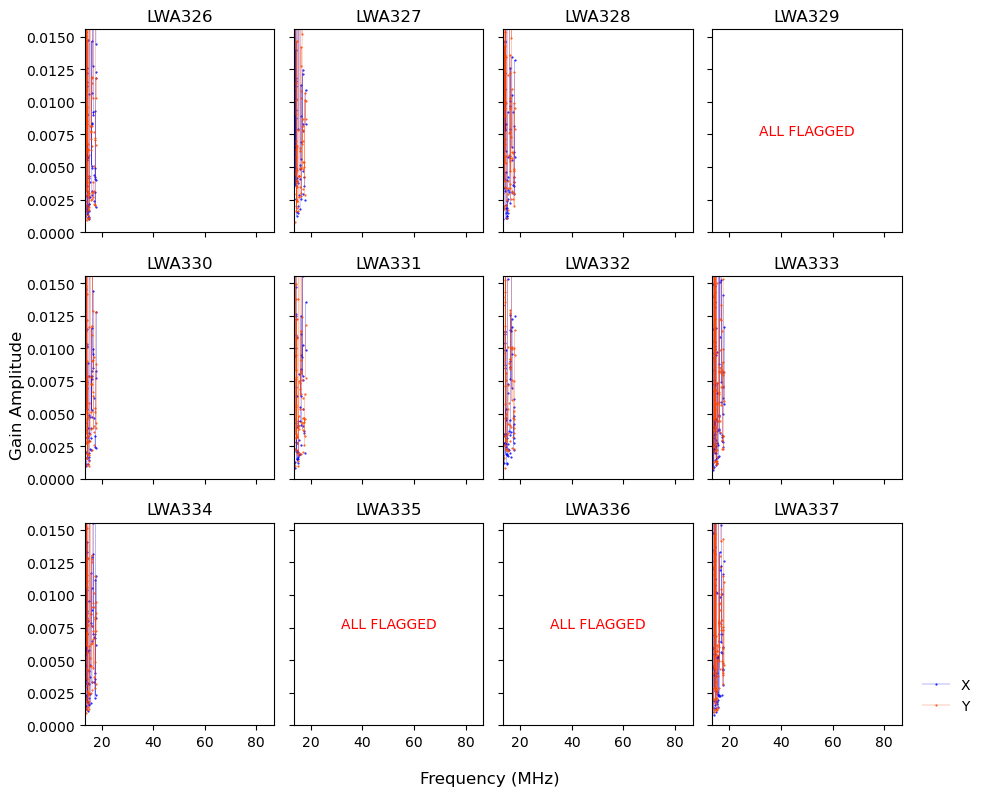

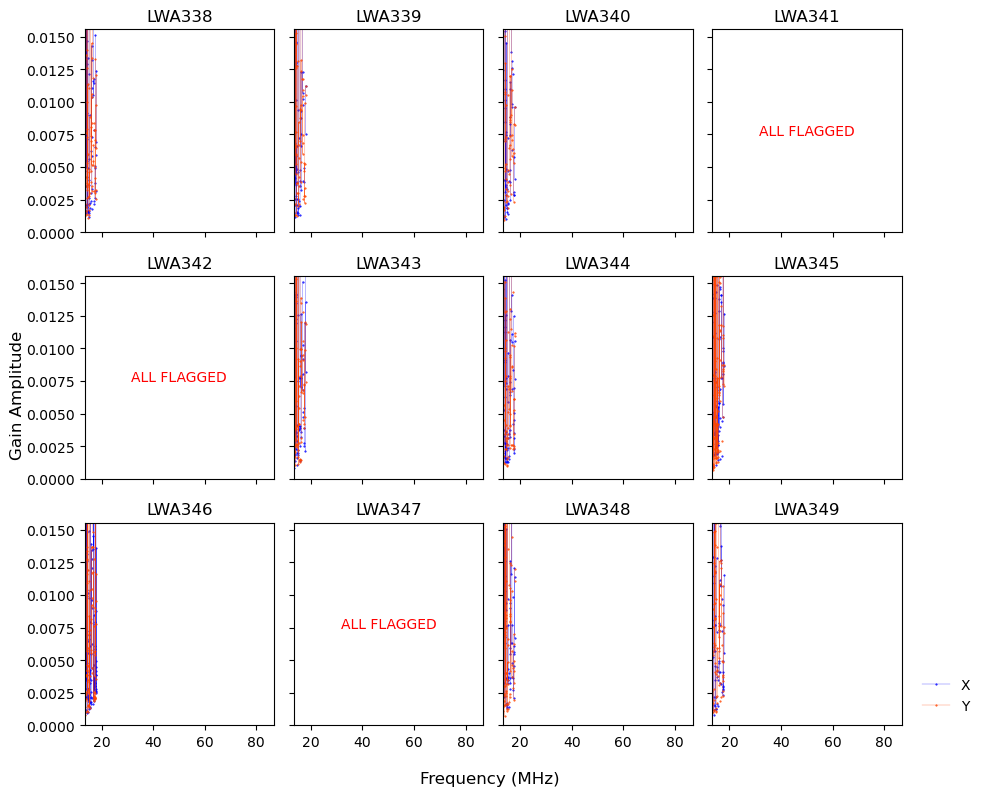

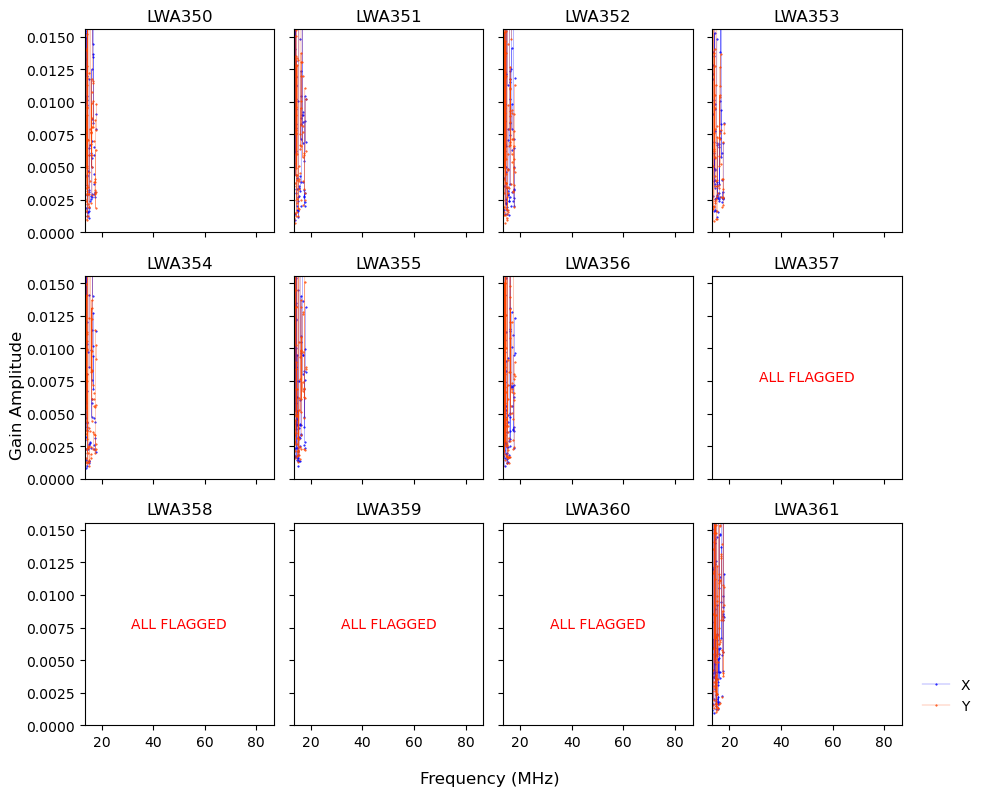

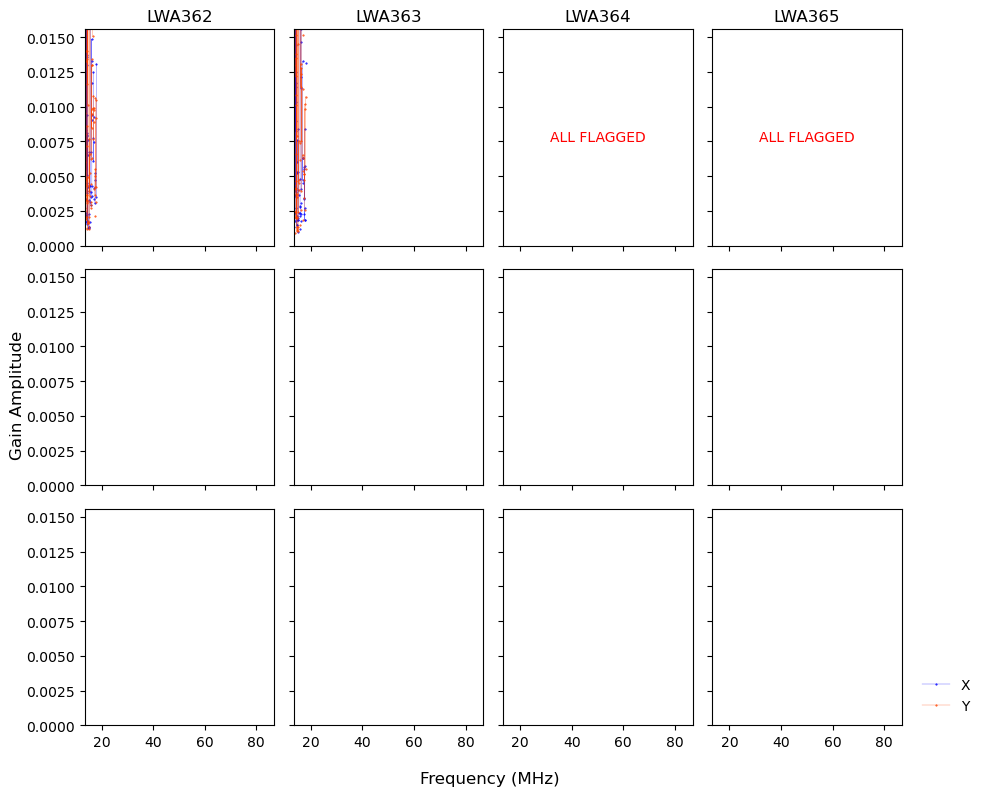

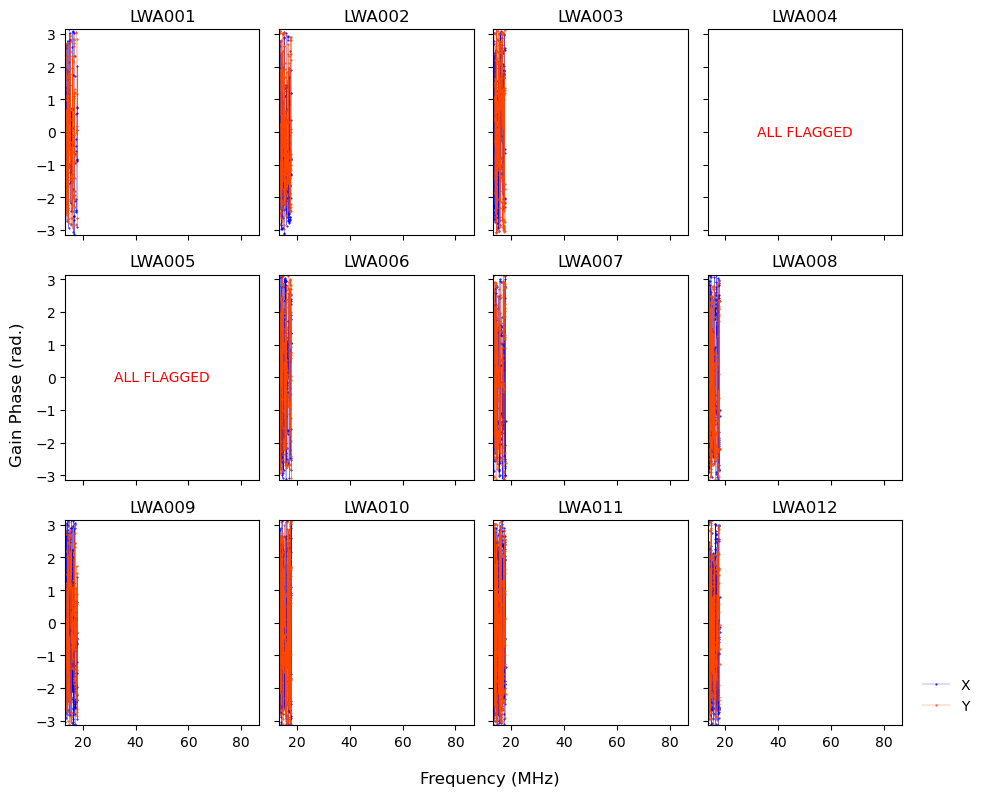

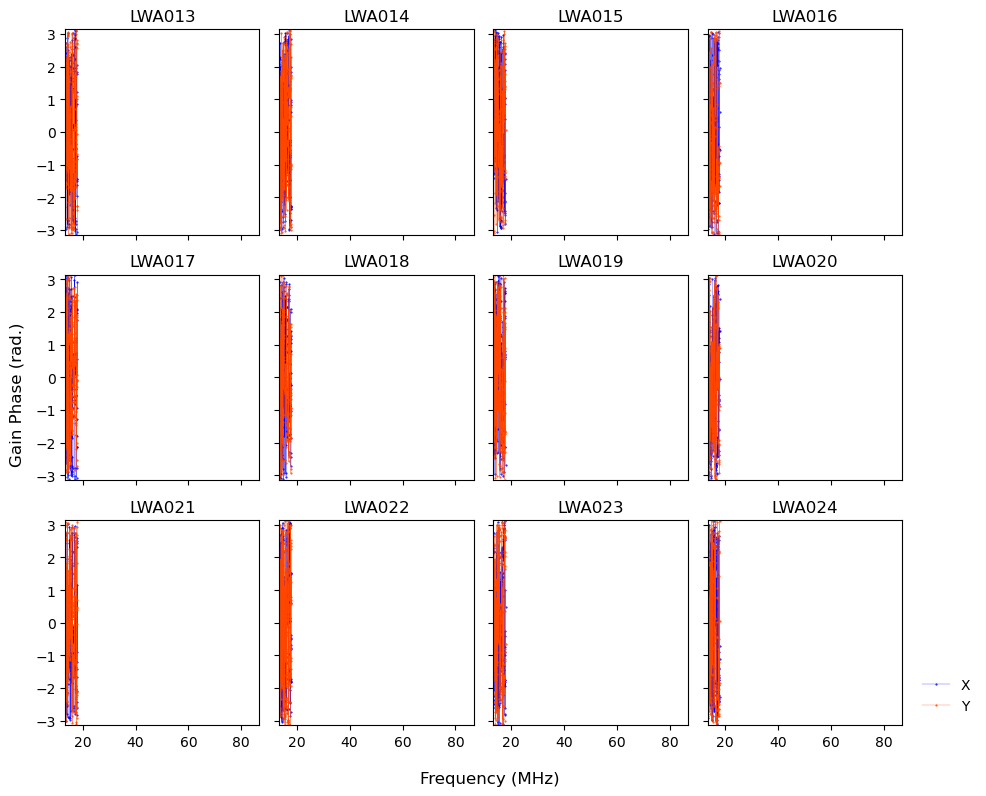

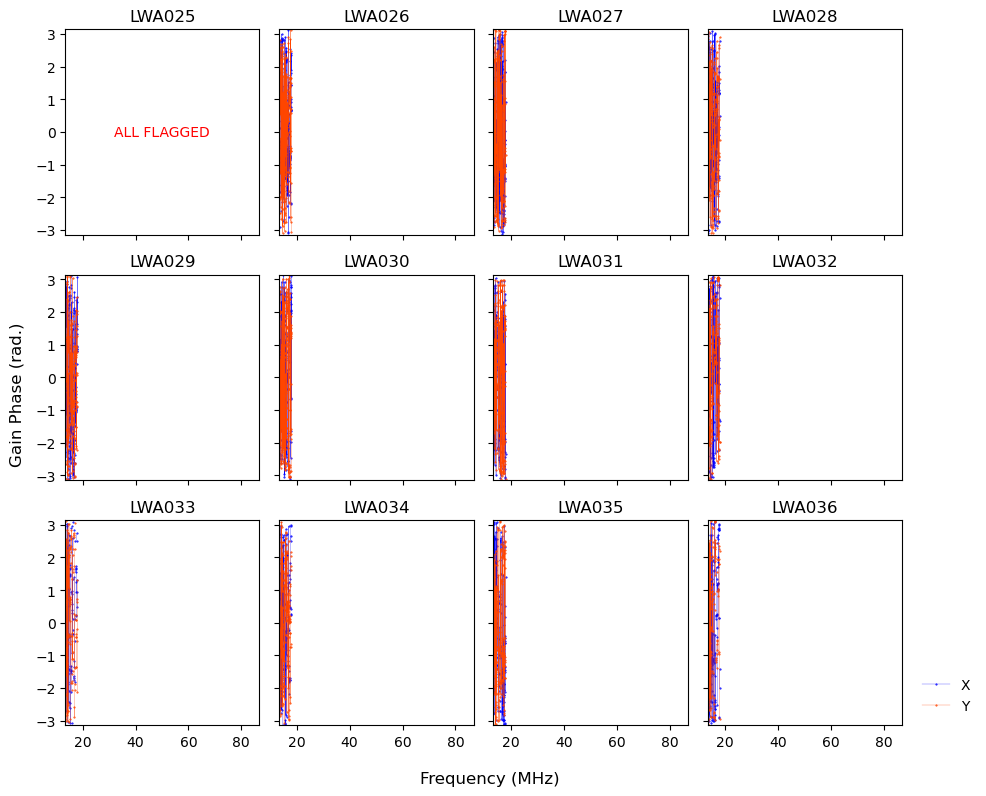

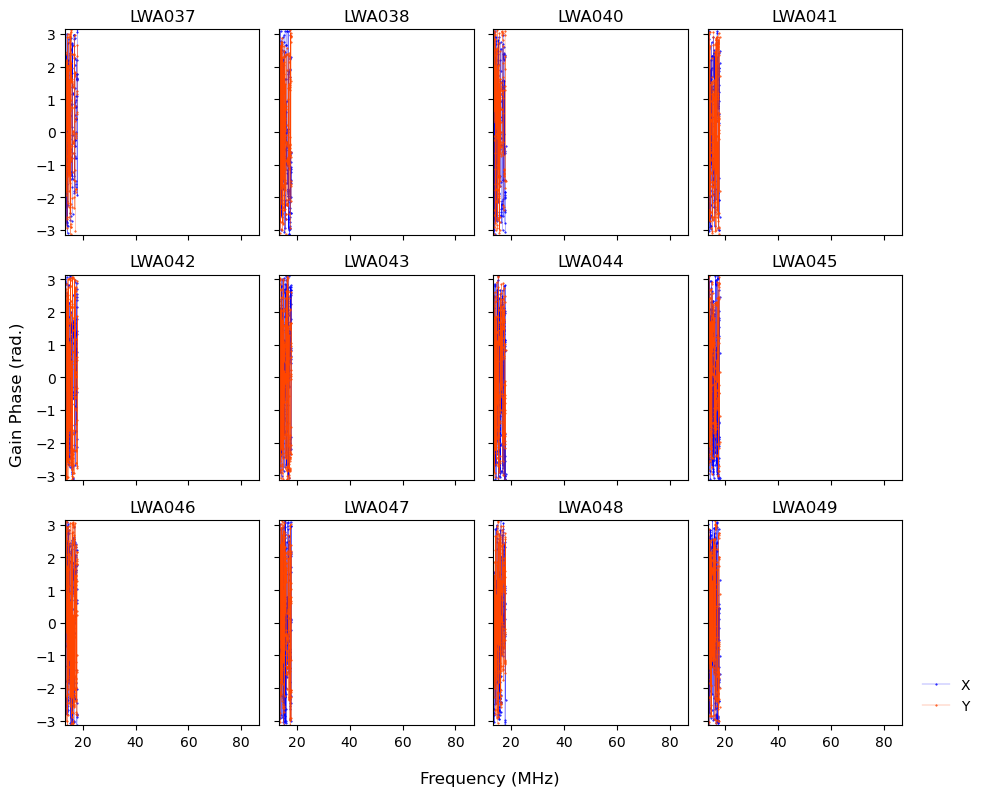

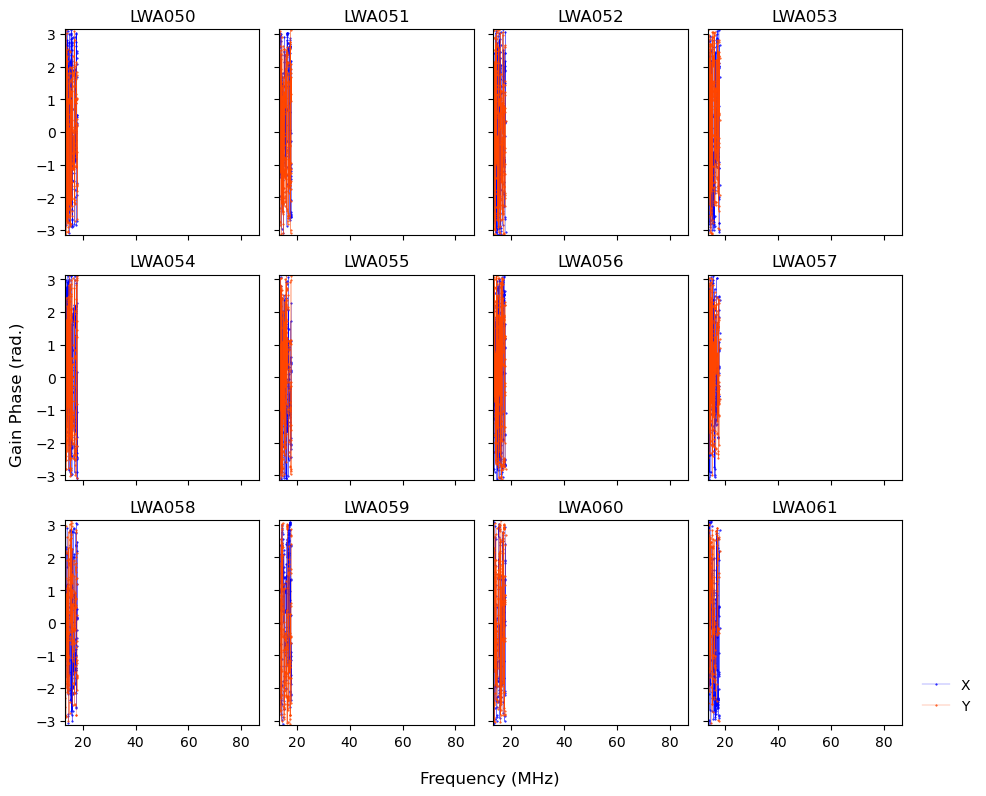

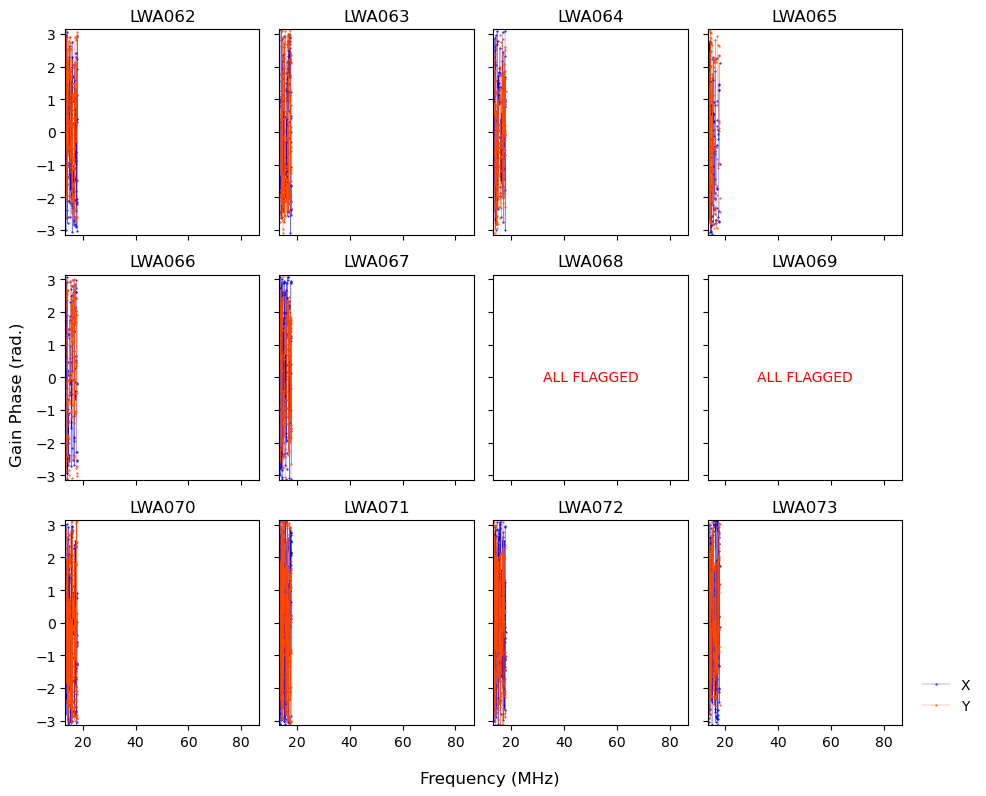

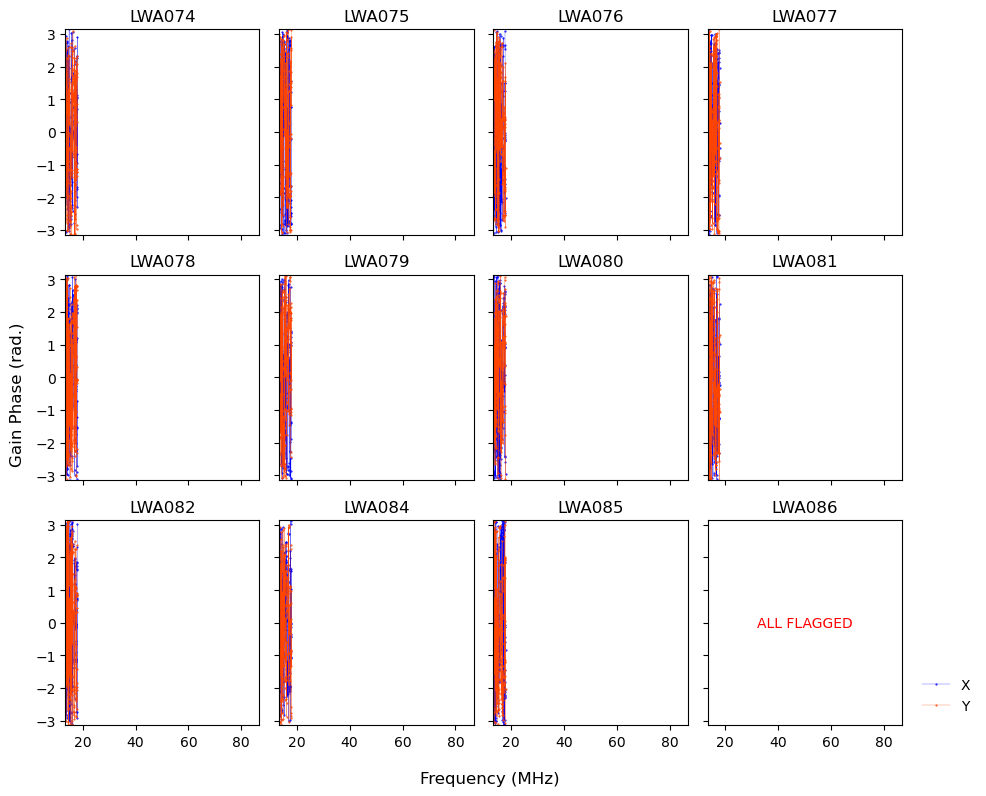

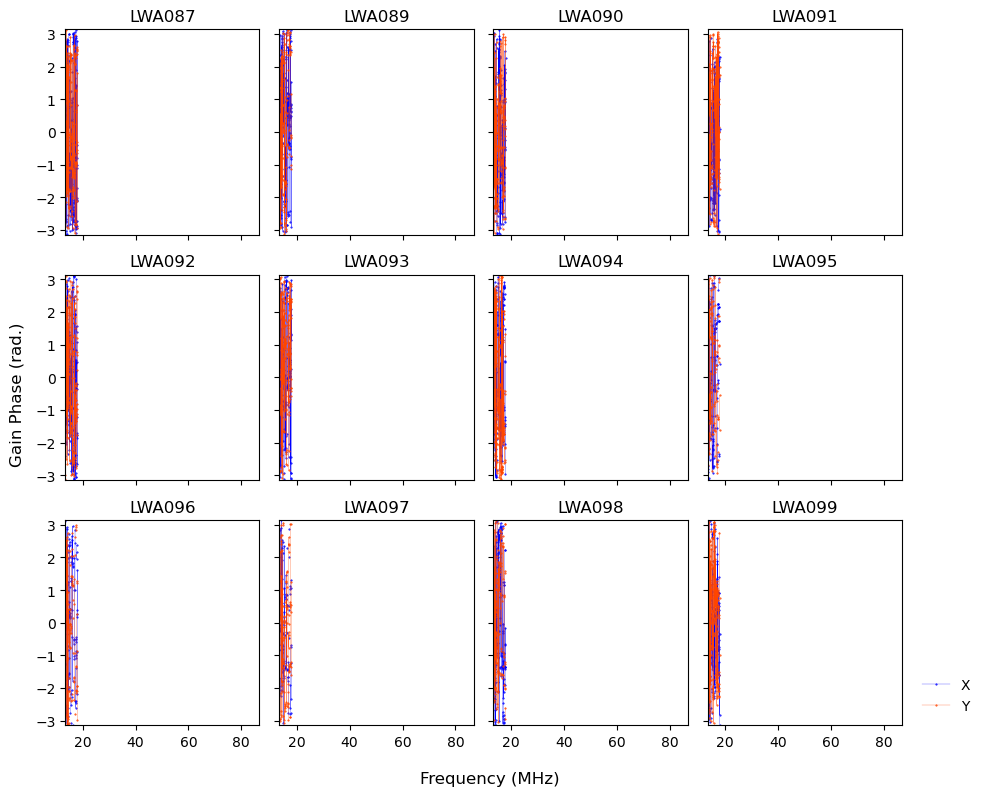

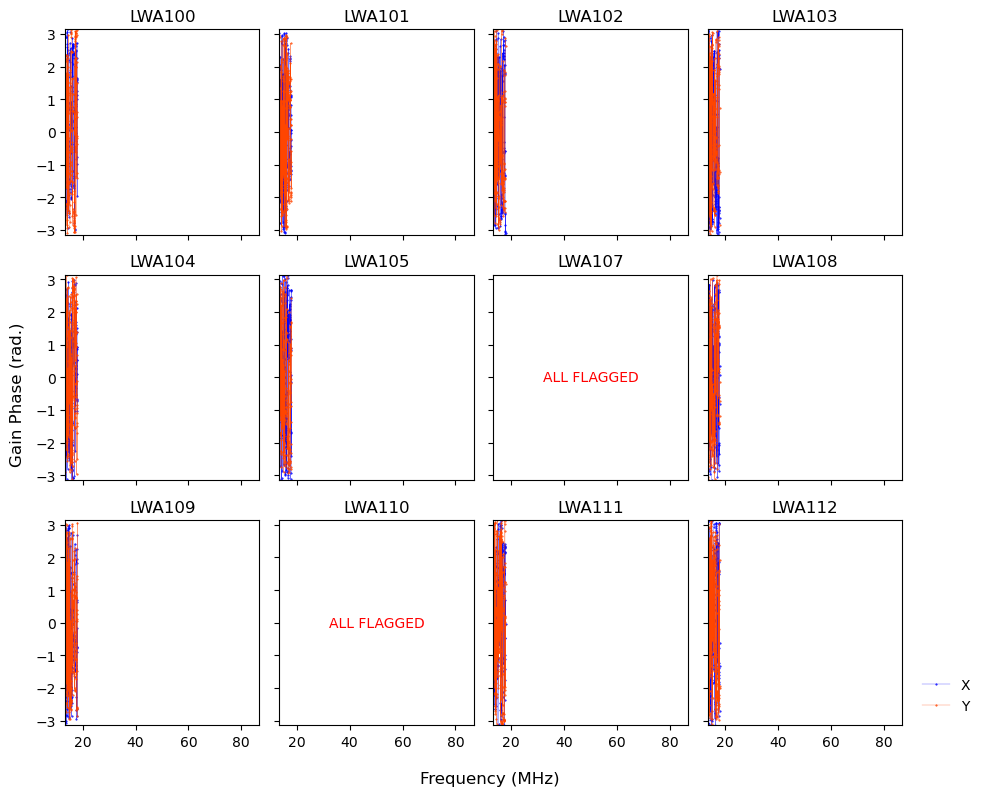

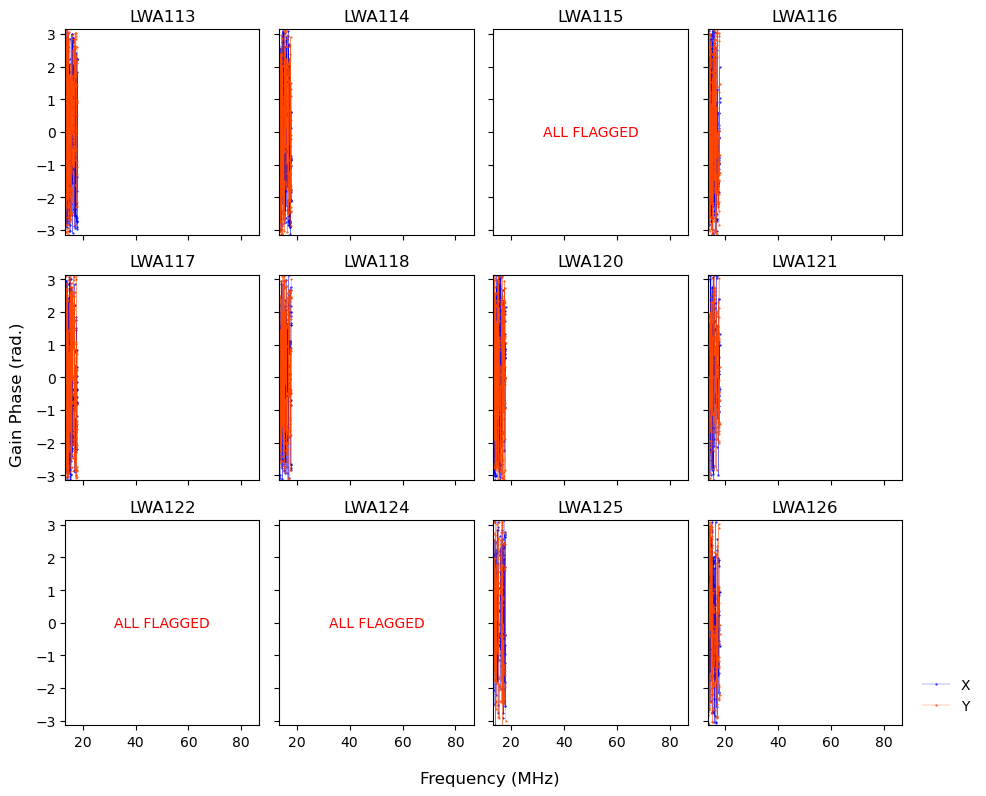

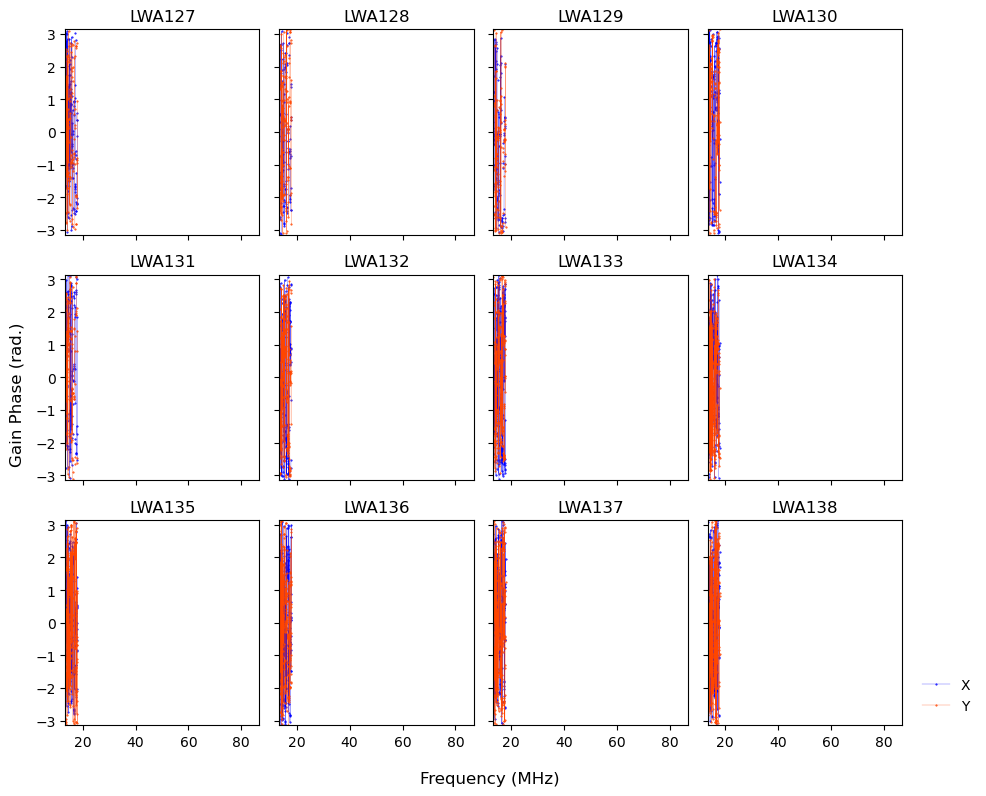

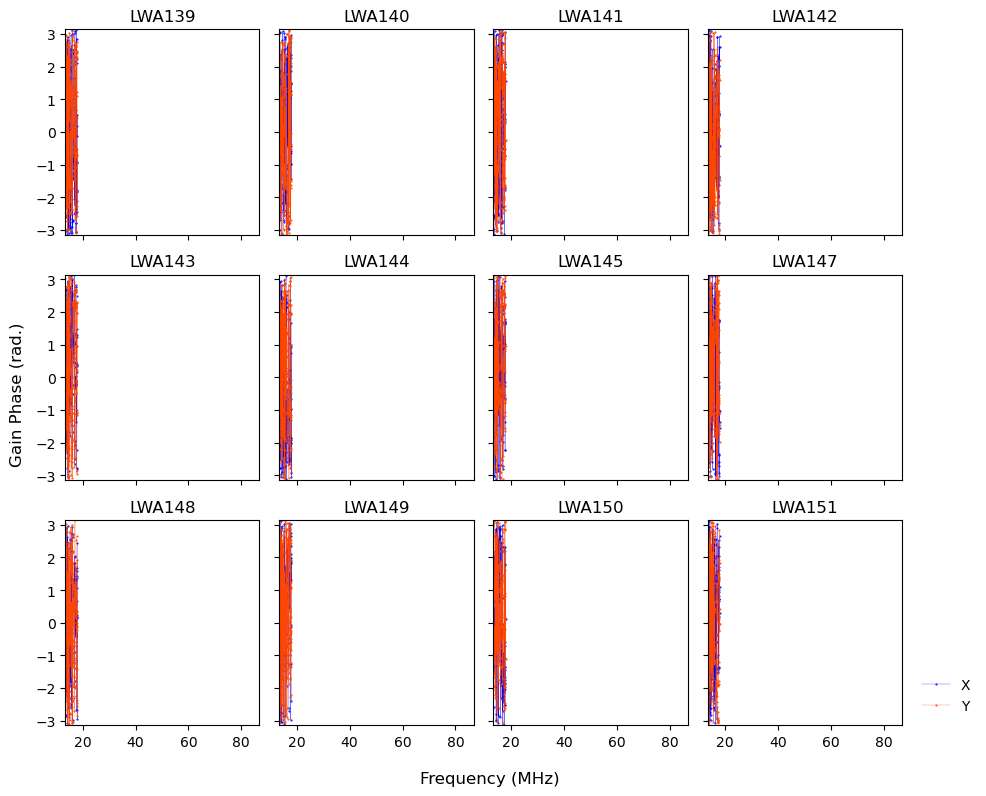

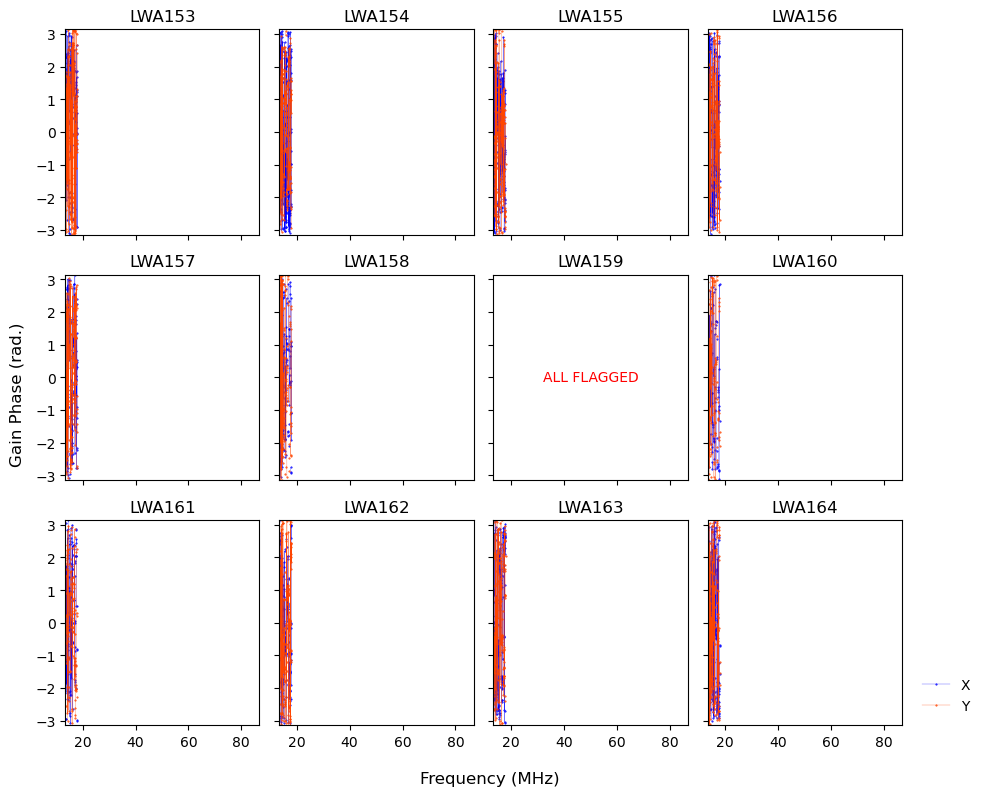

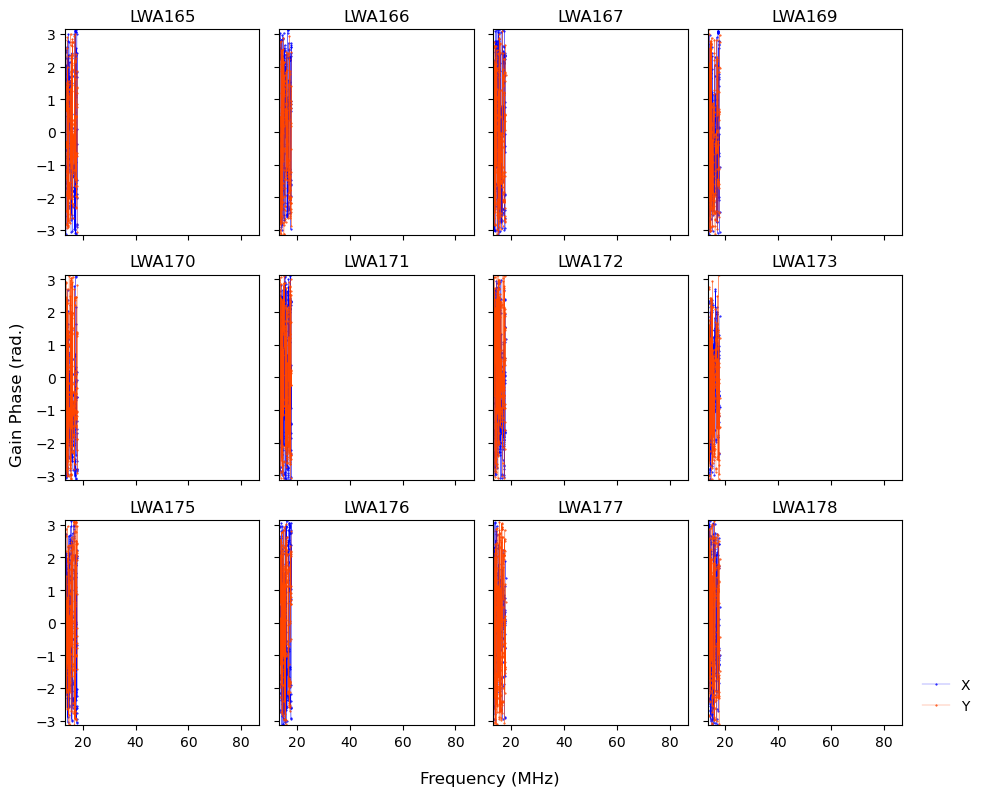

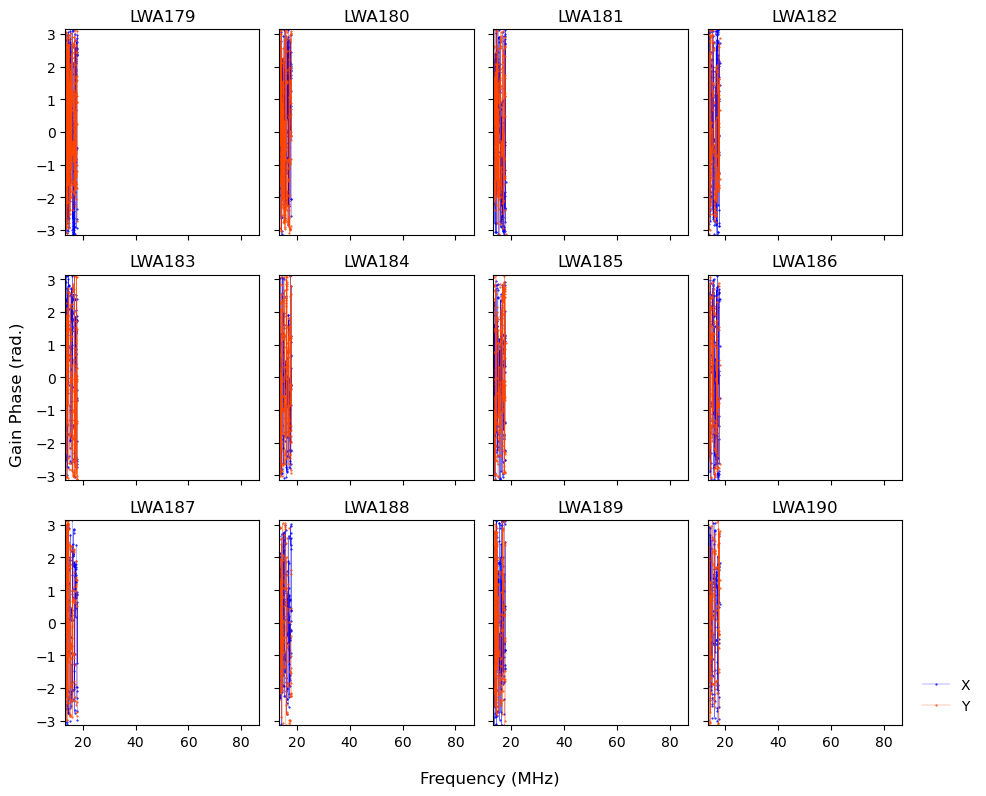

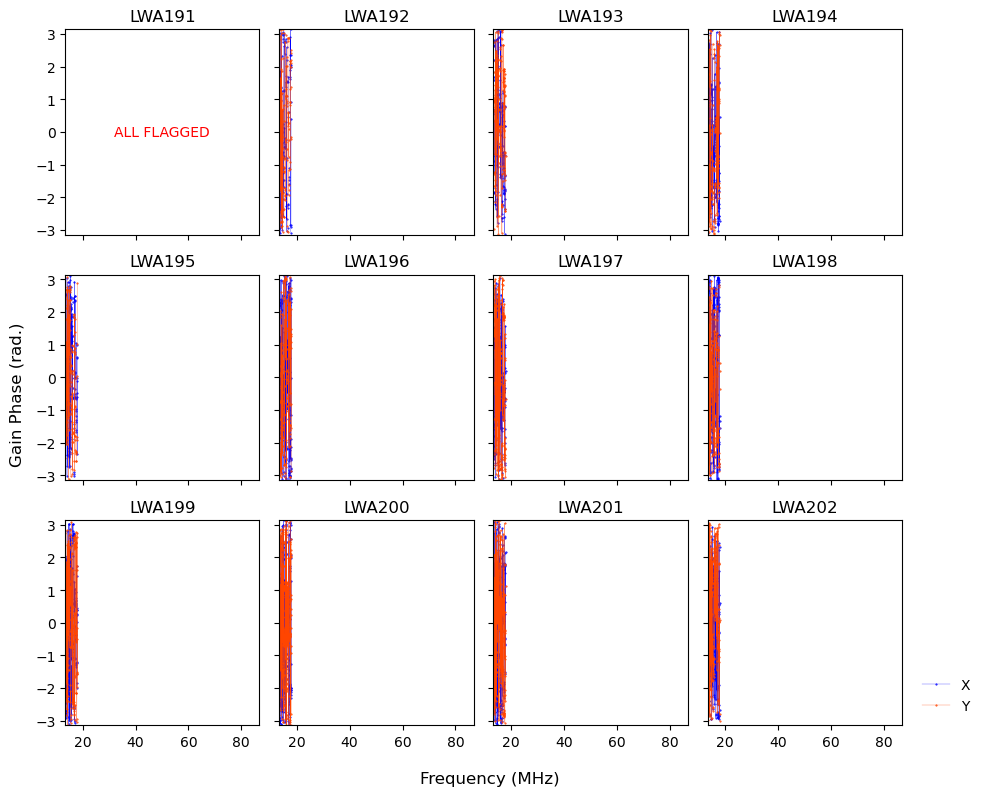

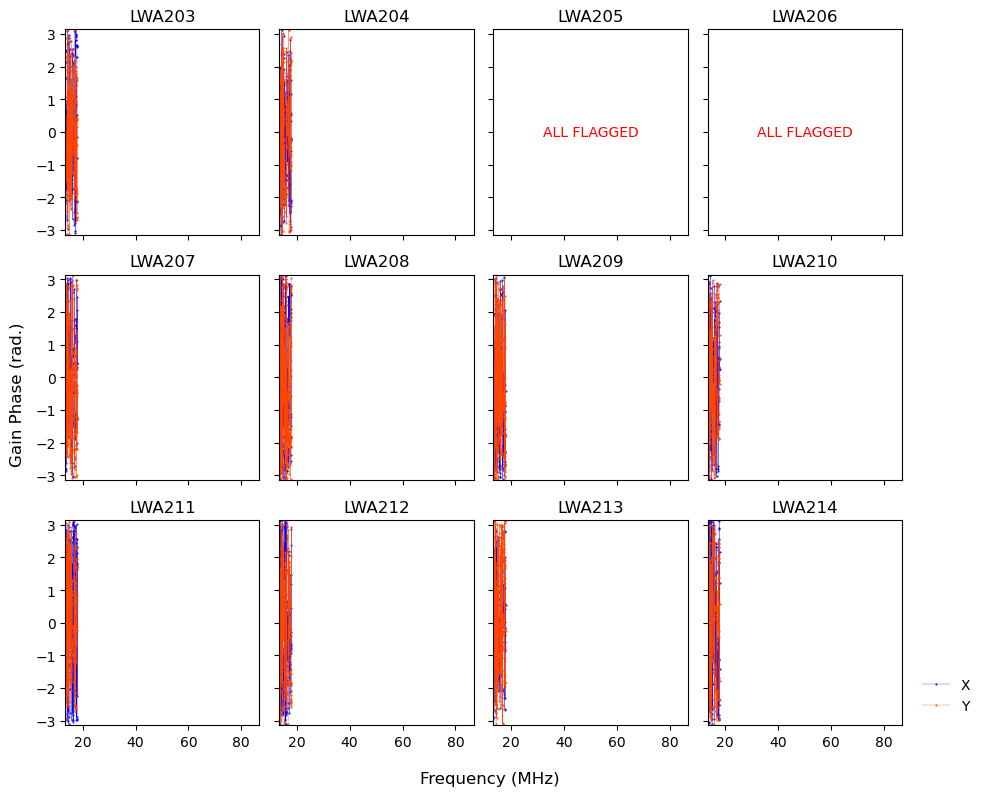

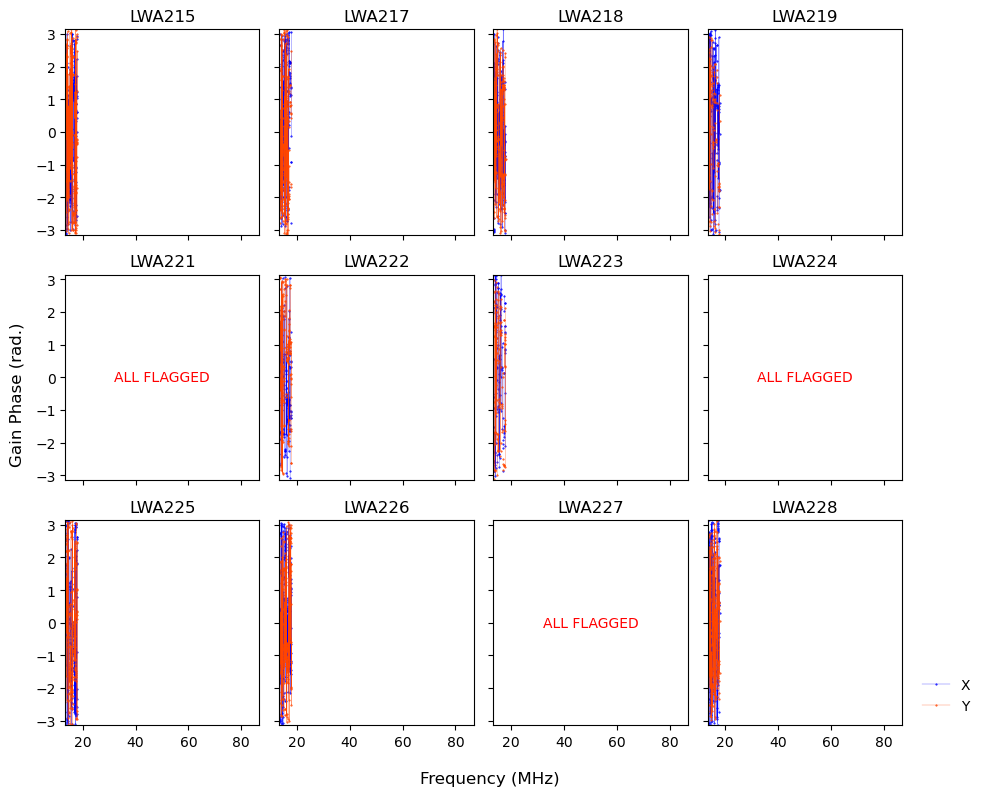

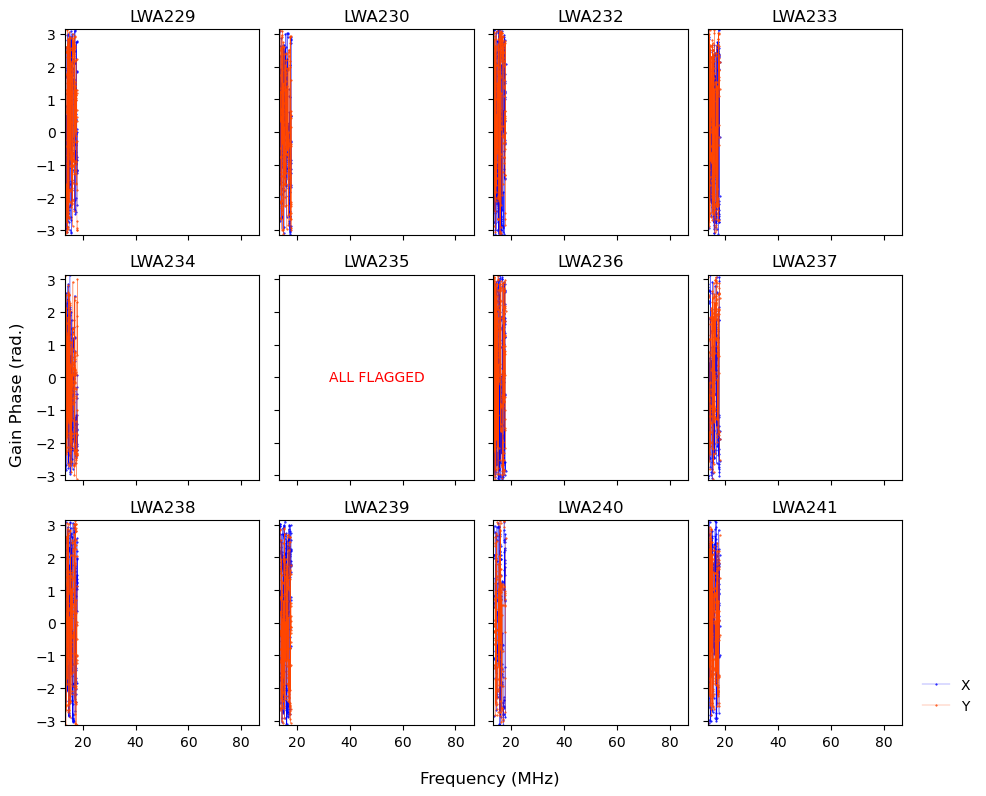

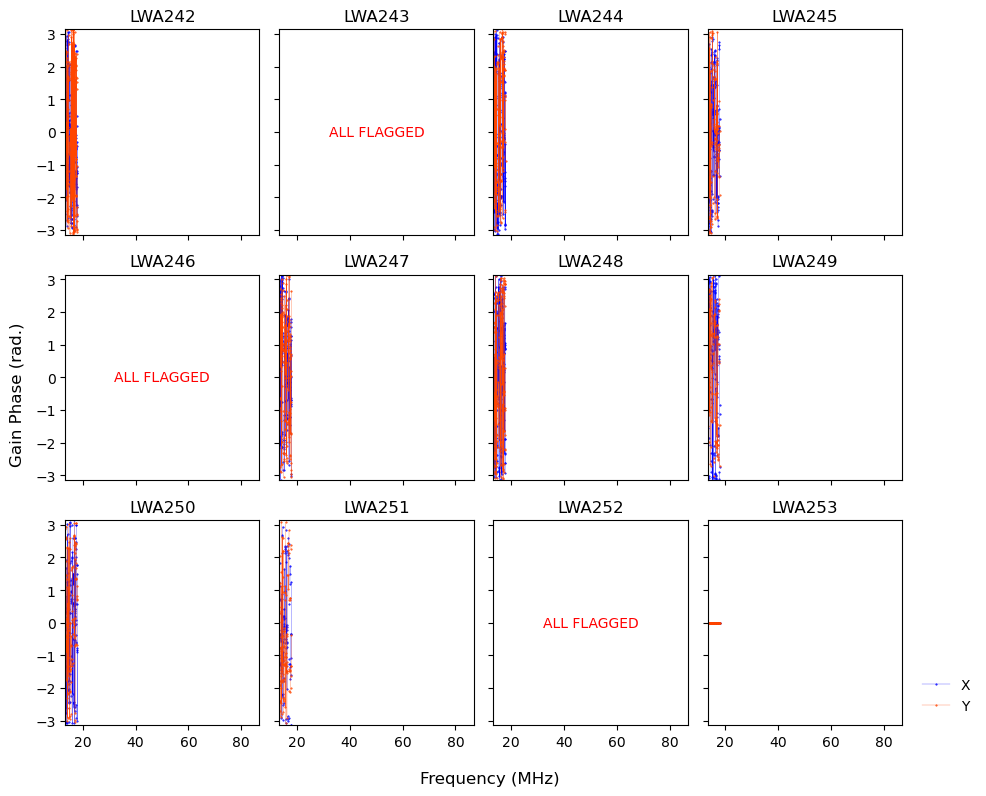

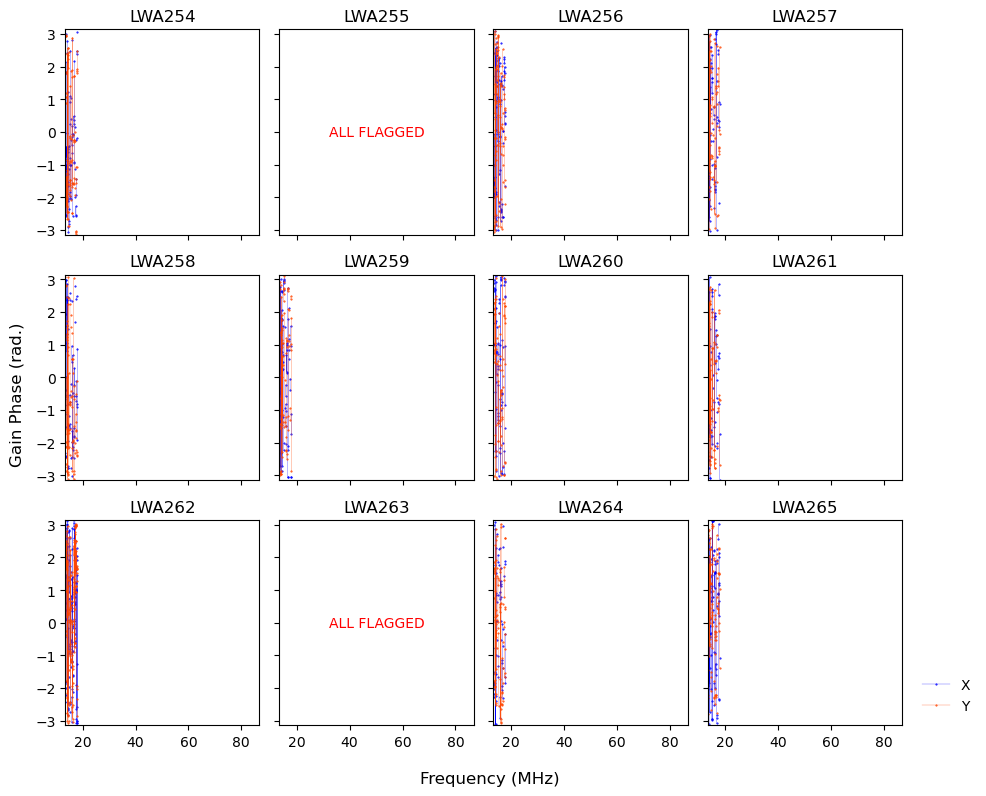

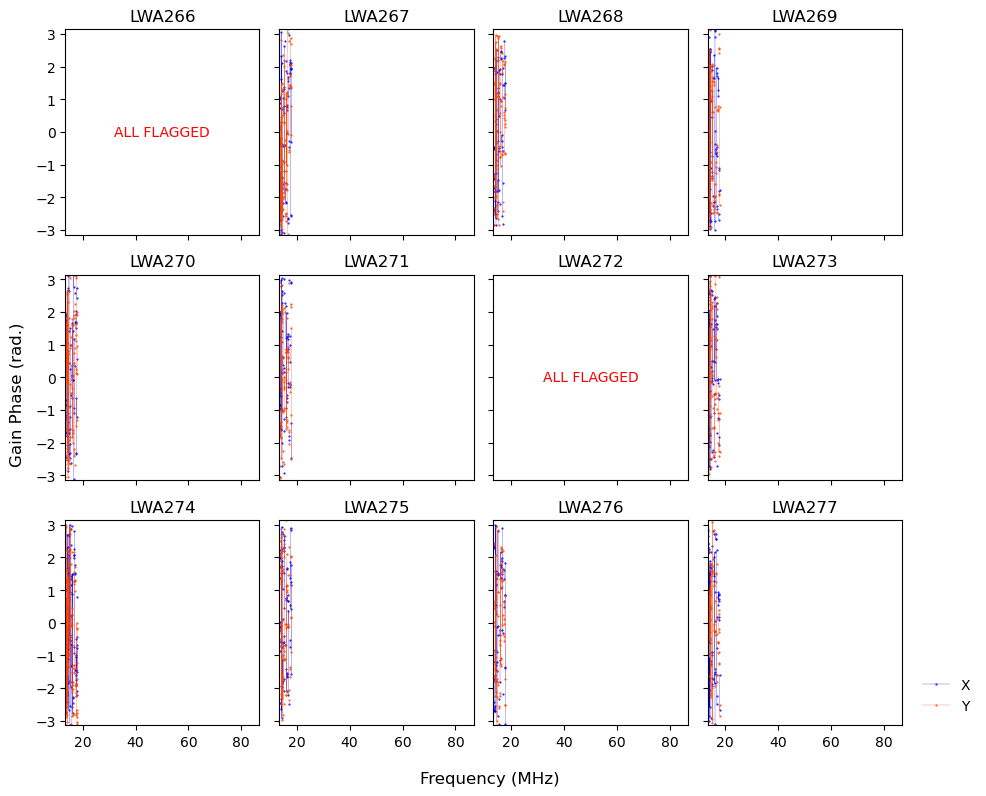

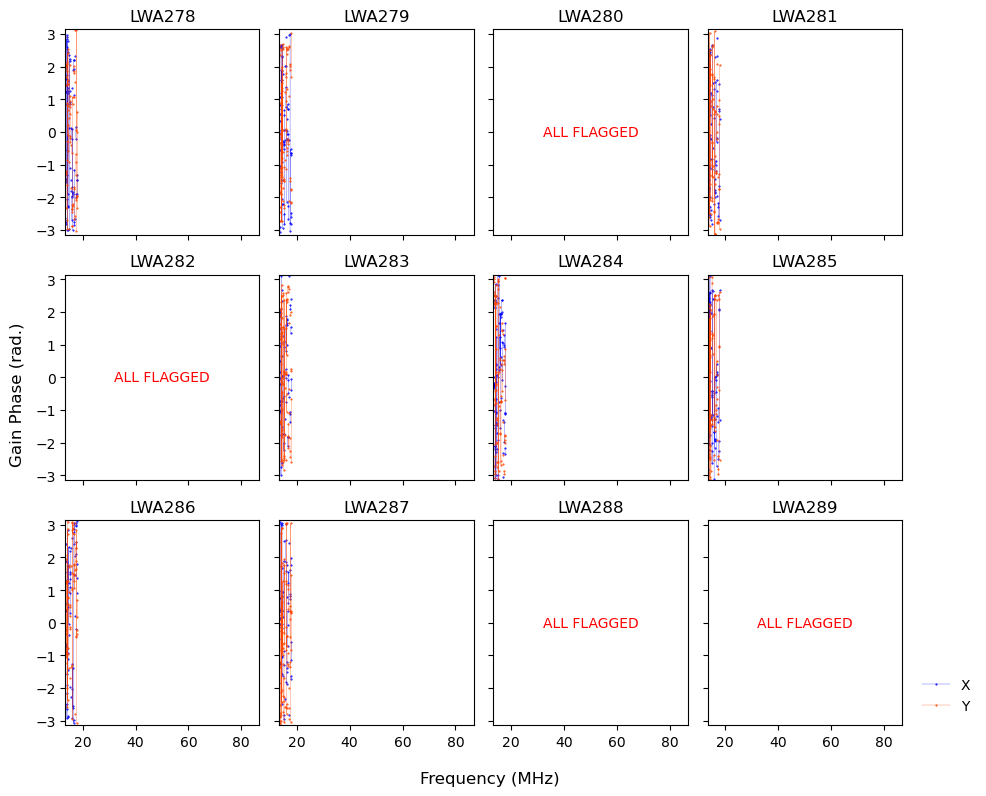

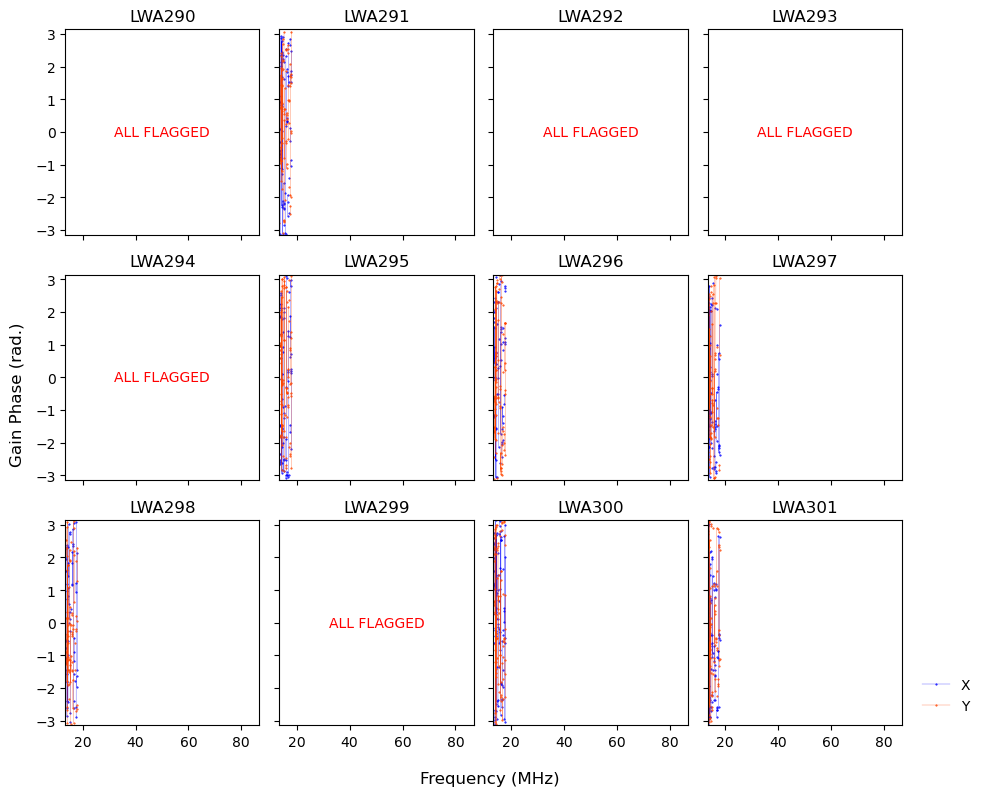

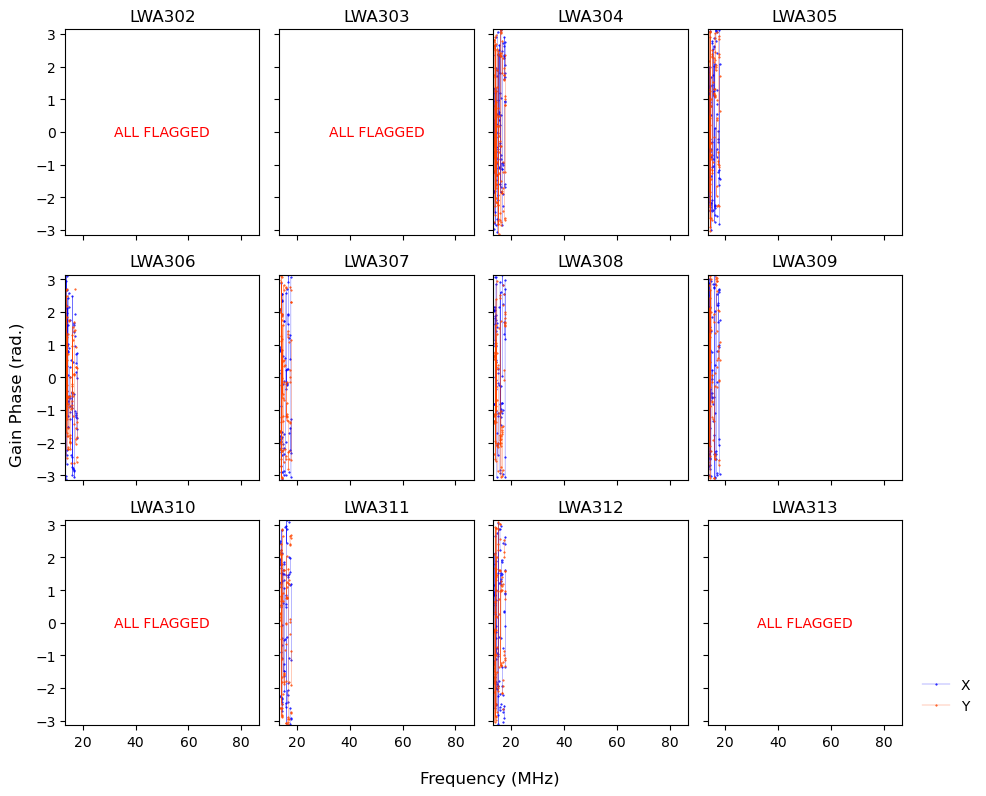

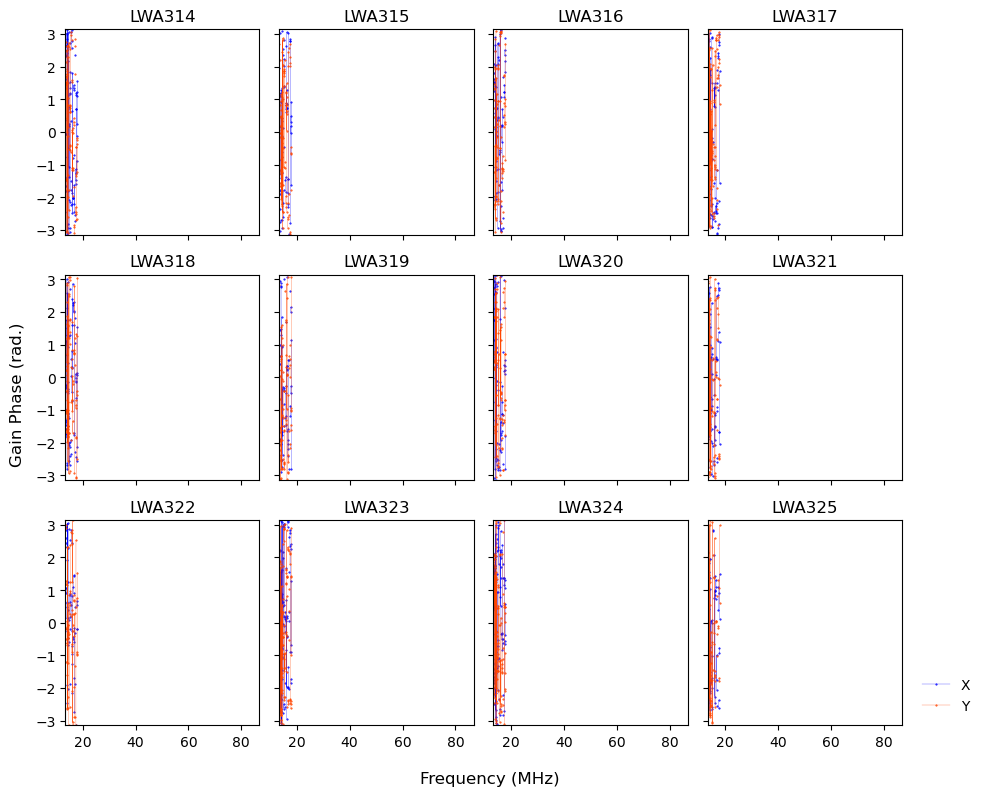

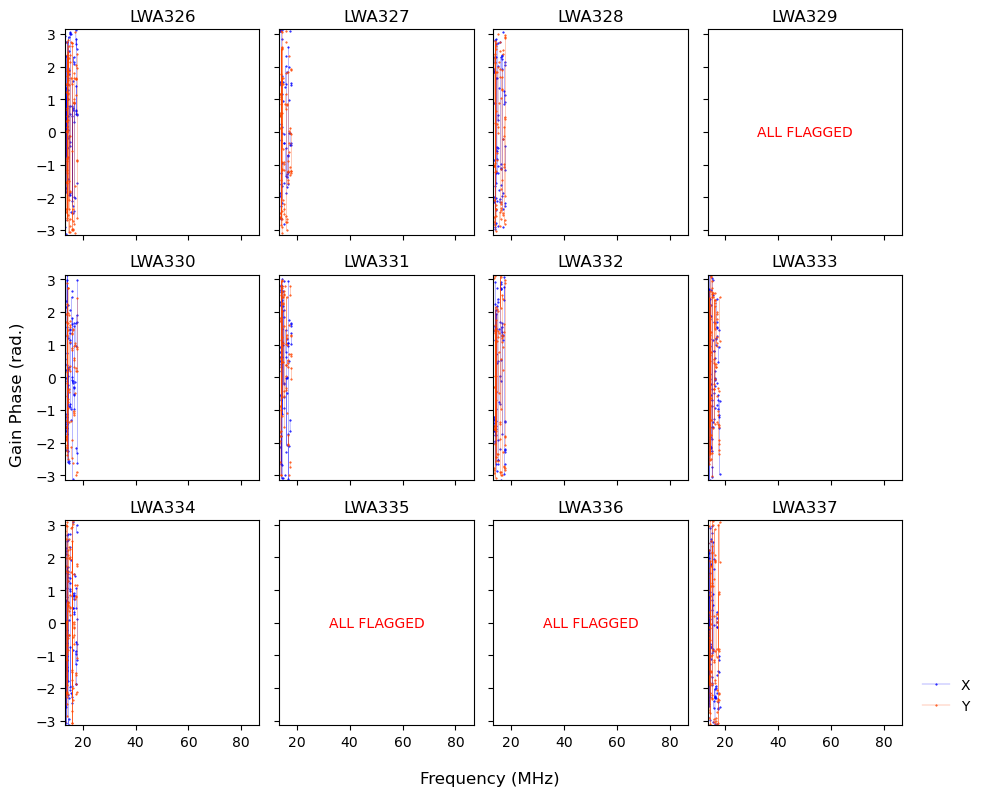

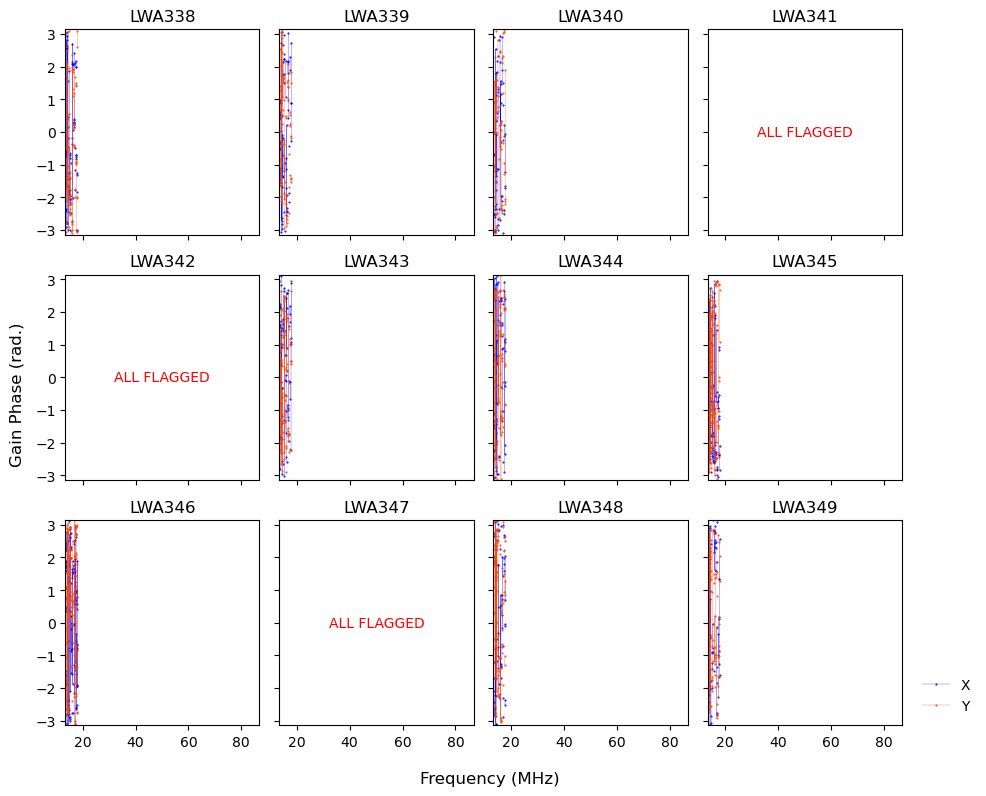

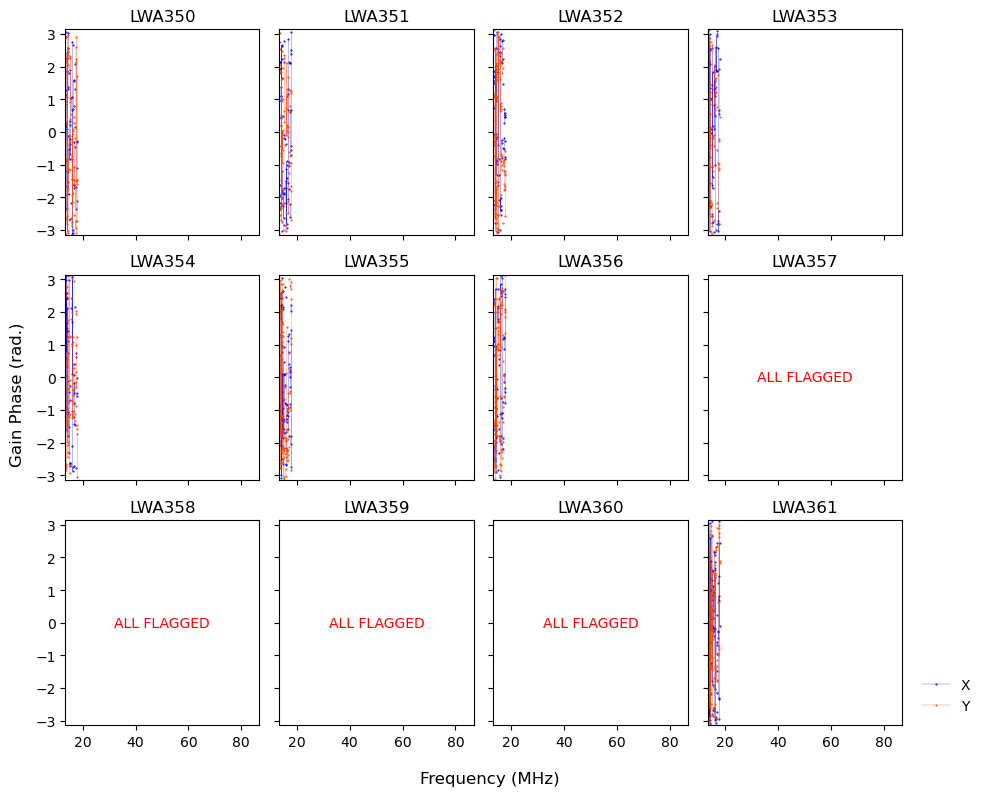

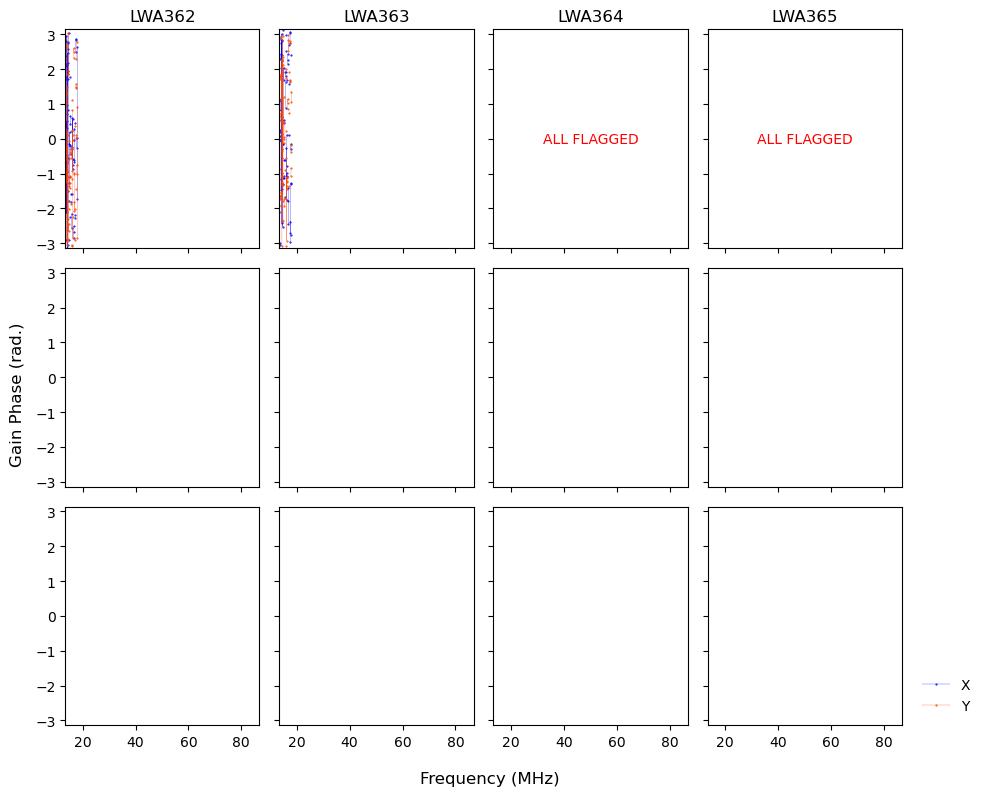

In [ ]:
cal = pyuvdata.UVCal()
cal.read_ms_cal(
    "/lustre/pipeline/calibration/results/2026-01-12/23h/successful/20260115_162611/tables/calibration_2026-01-12_23h.B"
)
calibration_qa.plot_gains(cal, savefig=False)

In [ ]:
cal.freq_array

array([13398437.5    , 13422363.28125, 13446289.0625 , ...,
       86826660.15625, 86850585.9375 , 86874511.71875], shape=(3072,))

In [ ]:
cal.gain_array

array([[[[        nan           +nanj,         nan           +nanj],
         [        nan           +nanj,         nan           +nanj],
         [        nan           +nanj,         nan           +nanj],
         ...,
         [        nan           +nanj,         nan           +nanj],
         [        nan           +nanj,         nan           +nanj],
         [        nan           +nanj,         nan           +nanj]],

        [[        nan           +nanj,         nan           +nanj],
         [        nan           +nanj,         nan           +nanj],
         [        nan           +nanj,         nan           +nanj],
         ...,
         [        nan           +nanj,         nan           +nanj],
         [        nan           +nanj,         nan           +nanj],
         [        nan           +nanj,         nan           +nanj]],

        [[        nan           +nanj,         nan           +nanj],
         [        nan           +nanj,         nan           +nanj],
  

In [ ]:
cal.flag_array

array([[[[ True,  True],
         [ True,  True],
         [ True,  True],
         ...,
         [ True,  True],
         [ True,  True],
         [ True,  True]],

        [[ True,  True],
         [ True,  True],
         [ True,  True],
         ...,
         [ True,  True],
         [ True,  True],
         [ True,  True]],

        [[ True,  True],
         [ True,  True],
         [ True,  True],
         ...,
         [ True,  True],
         [ True,  True],
         [ True,  True]],

        ...,

        [[ True,  True],
         [ True,  True],
         [ True,  True],
         ...,
         [ True,  True],
         [ True,  True],
         [ True,  True]],

        [[ True,  True],
         [ True,  True],
         [ True,  True],
         ...,
         [ True,  True],
         [ True,  True],
         [ True,  True]],

        [[ True,  True],
         [ True,  True],
         [ True,  True],
         ...,
         [ True,  True],
         [ True,  True],
         [ True, 